In [1]:
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import itertools
import numpy as np

from apps import cex_analyse, cex_toy_parameters
from python.analysis import cross_section, Master, Plots
from rich import print
cross_section.SetPlotStyle(True, dpi = 100)

def PlotObservableComparison(inputs : dict[cross_section.AnalysisInput], obs : str, bins, xlabel : str):
    tags = {k : cross_section.Tags.ExclusiveProcessTags(v.exclusive_process) for k, v in inputs.items()}    
    x = (bins[1:] + bins[:-1]) / 2

    styles = CreateStyles()

    for _, k in Plots.IterMultiPlot(list(tags.values())[0]):
        for e, i in enumerate(inputs):
            hist = np.histogram(getattr(inputs[i], obs)[tags[i][k].mask], bins)[0]
            Plots.Plot(x, hist/sum(hist), yerr = np.sqrt(hist)/sum(hist), color = f"C{2*e}", style = styles[e % len(styles)][0], marker = styles[e % len(styles)][1], linestyle = styles[e % len(styles)][2], label = i, title = k, newFigure = False)
        Plots.plt.xlabel(xlabel)
        Plots.plt.ylabel("fractional counts")
    return


def PlotMCToyComparison(mc : cross_section.AnalysisInput, toy : cross_section.AnalysisInput, obs : str, bins, xlabel : str):
    tags_mc = cross_section.Tags.ExclusiveProcessTags(mc.exclusive_process)
    tags_toy = cross_section.Tags.ExclusiveProcessTags(toy.exclusive_process)
    x = (bins[1:] + bins[:-1]) / 2
    for _, k in Plots.IterMultiPlot(tags_mc):
        h_m = np.histogram(getattr(mc, obs)[tags_mc[k].mask], bins)[0]
        h_t = np.histogram(getattr(toy, obs)[tags_toy[k].mask], bins)[0]
        Plots.Plot(x, h_m/sum(h_m), yerr = np.sqrt(h_m)/sum(h_m), style = "step", color = tags_mc[k].colour, label = "MC", newFigure = False)
        Plots.Plot(x, h_t/sum(h_t), yerr = np.sqrt(h_t)/sum(h_t), marker = "o", color = tags_toy[k].colour, label = "toy", linestyle = "", xlabel = xlabel, ylabel = "fractional counts", title = k, newFigure = False)
    return


def PlotAnalysisInputRatio(data1 : cross_section.AnalysisInput, data2 : cross_section.AnalysisInput, observable : str, bins : np.array, xlabel : str = None, ratio_label : str = "data2/data1", label_1 : str = "data 1", label_2 : str = "data 2", norm : float = None, weights_1 : np.array = None, weights_2 : np.array = None):
    if norm is None:
        count_1 = len(data1.inclusive_process) if weights_1 is None else sum(weights_1)
        count_2 = len(data2.inclusive_process) if weights_2 is None else sum(weights_2)
        norm = count_2/count_1
    # print(f"{count_2, count_1, count_2/count_1=}")
    h_1 = np.array(np.histogram(getattr(data1, observable), bins, weights = weights_1)[0] * norm, dtype = int)
    h_2 = np.histogram(getattr(data2, observable), bins, weights = weights_2)[0]
    with Plots.RatioPlot(cross_section.bin_centers(bins), h_1, h_2, np.sqrt(h_1), np.sqrt(h_2), xlabel, ratio_label) as ratio_plot:
        Plots.Plot(ratio_plot.x, ratio_plot.y2, yerr = ratio_plot.y2_err, label=f"{label_2}: {sum(ratio_plot.y2)}", style = "step", color = "C6", newFigure = False)
        Plots.Plot(ratio_plot.x, ratio_plot.y1, yerr = ratio_plot.y1_err, label=f"{label_1}: {sum(ratio_plot.y1)}", marker = "x", linestyle = "", color = "k", ylabel = "Counts", newFigure = False)
        
        h, l = Plots.plt.gca().get_legend_handles_labels()
        Plots.plt.legend(h + [Plots.matplotlib.patches.Rectangle((0,0), 0, 0, fill = False, edgecolor='none', visible=False)], l + [f"norm: {norm:.3g}"], loc = "best", ncols = 1, labelspacing = 0.25,  columnspacing = 0.25)


def CreateStyles():
    style = ["step", "scatter"]
    marker = [None, "o", "x", "+"]
    linestyle = ["", "-", "--", "-."]

    styles = itertools.product(style, marker, linestyle)
    selected_styles = []
    for s in styles:
        if (s[0] == "step") and (s[1] is None) and (s[2] != ""): selected_styles.append(s)
        if (s[0] == "scatter") and (s[1] is None) and (s[2] != ""): selected_styles.append(s)
        if (s[0] == "scatter") and (s[1] is not None) and (s[2] == ""): selected_styles.append(s)

    selected_styles = selected_styles[:3] + selected_styles[6:] + selected_styles[3:6]
    selected_styles = selected_styles[::3] + selected_styles[1::3] + selected_styles[2::3]
    return selected_styles


def CreateAnalysisInputMCTrueBeam(mc : Master.Data, args : cross_section.argparse.Namespace):
    is_pip = mc.trueParticles.pdg[:, 0] == 211
    mc_true_beam = mc.Filter([is_pip], [is_pip], True)

    n_pi =  cross_section.EventSelection.SelectionTools.GetPFOCounts(args.selection_masks["mc"]["pi"])
    n_pi0 = cross_section.EventSelection.SelectionTools.GetPFOCounts(args.selection_masks["mc"]["pi0"])
    reco_regions = cross_section.EventSelection.create_regions_new(n_pi0, n_pi)


    n_pi_true = mc_true_beam.trueParticles.nPiMinus + mc_true_beam.trueParticles.nPiPlus
    n_pi0_true = mc_true_beam.trueParticles.nPi0
    true_regions = cross_section.EventSelection.create_regions_new(n_pi0_true, n_pi_true)

    return cross_section.AnalysisInput.CreateAnalysisInputNtuple(mc_true_beam, args.upstream_loss_correction_params["value"], reco_regions, true_regions, args.beam_reweight_params)


def CreateAnalysisInputs(args, p_mom : float):
    mc = Master.Data(args.mc_file, nTuple_type = args.ntuple_type)
    analysis_input_mc_s = cex_analyse.CreateAnalysisInput(mc, args, True) # beam particle selection
    analysis_input_mc = CreateAnalysisInputMCTrueBeam(mc, args) # truth beam (reco regions won't work)

    analysis_input_mc.ToFile(f"test/analysis_inputs/analysis_input_{p_mom}GeV_mc_cheated.dill")
    analysis_input_mc_s.ToFile(f"test/analysis_inputs/analysis_input_{p_mom}GeV_mc_selected.dill")

    data = Master.Data(args.data_file, nTuple_type = args.ntuple_type)
    analysis_input_data_s = cex_analyse.CreateAnalysisInput(data, args, False)
    analysis_input_data_s.ToFile(f"test/analysis_inputs/analysis_input_{p_mom}GeV_data_selected.dill")
    print("rerun notebook with create_ai = False")
    return


def CompareFitResults(region_fit_result, analysis_input : cross_section.AnalysisInput, energy_slices : cross_section.Slices, mean_track_score_bins : np.array, book : Plots.PlotBook = Plots.PlotBook.null):
    KE_int_prediction = cross_section.RegionFit.SliceModelPrediction(region_fit_result, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score

    total_yield_KE = np.sum(np.sum(KE_int_prediction.model_yields, 0), 1)

    print(f"{total_yield_KE, sum(total_yield_KE)=}")

    actual_yield_KE = []

    for _, (n, n_err, k) in Plots.IterMultiPlot(list(zip(np.sum(KE_int_prediction.model_yields, 0), np.sum(KE_int_prediction.total_stdev_model_bins[:, :-1], 0), analysis_input.exclusive_process.keys()))):
        true = cross_section.EnergySlice.CountingExperiment(analysis_input.KE_int_reco, analysis_input.KE_init_reco, analysis_input.outside_tpc_reco, analysis_input.exclusive_process[k], energy_slices, True)
        Plots.Plot(np.array(range(len(n))), true, label = "actual", style = "bar", color = "C6", title = f"MC | {k}", newFigure = False)
        Plots.Plot(np.array(range(len(n))), n, yerr = n_err, label = "fit", style = "step", color = "k", newFigure = False, xlabel = "$N_{int}$")
        actual_yield_KE.append(np.sum(true))
    if book: book.Save()

    print(f"{actual_yield_KE, sum(actual_yield_KE)=}")

    if mean_track_score_bins is not None:
        track_score_prediction = cross_section.RegionFit.SliceModelPrediction(region_fit_result, slice(4, 5), "mean_track_score_post")

        total_yield_score = np.sum(track_score_prediction.model_yields[0], 1)
        print(f"{total_yield_score, sum(total_yield_score)=}")

        track_scores_actual = [analysis_input.mean_track_score[analysis_input.exclusive_process[k]] for k in analysis_input.exclusive_process]

        actual_yield_score = [len(i) for i in track_scores_actual]
        print(f"{actual_yield_score, sum(actual_yield_score)=}")

        labels = list(analysis_input.exclusive_process.keys())

        Plots.plt.figure()
        for i in range(len(track_score_prediction.model_yields[0])):
            Plots.PlotHist(track_scores_actual[i], bins = mean_track_score_bins, histtype = "step", color = f"C{(2*i)}", label = labels[i], xlabel = "mean track score", newFigure = False)
            Plots.Plot((mean_track_score_bins[1:] + mean_track_score_bins[:-1]) / 2, track_score_prediction.model_yields[0][i], yerr = track_score_prediction.total_stdev_model_bins[0][i], label = "fit", color = f"C{(2*i+1)}", newFigure = False)
        book.Save()

        for i in Plots.MultiPlot(len(track_score_prediction.model_yields[0])):
            Plots.PlotHist(track_scores_actual[i], bins = mean_track_score_bins, histtype = "bar", color = f"C6", label = "actual", xlabel = "mean track score", title = labels[i], newFigure = False)
            Plots.Plot((mean_track_score_bins[1:] + mean_track_score_bins[:-1]) / 2, track_score_prediction.model_yields[0][i], yerr = track_score_prediction.total_stdev_model_bins[0][i], label = "fit", color = "k", style = "step", newFigure = False)
        book.Save()
    return

def loadAI(path):
    files = [i for i in cross_section.os.listdir(path) if ".dill" in i]
    ais = {}
    for f in files:
        if "data" in f:
            name = "data"
        elif "mc" in f:
            name = "mc"
        else:
            continue
        if "cheated" in f:
            name += "_c"
        ais[name] = cross_section.AnalysisInput.FromFile(path + f)
    return ais


env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [2]:
config = "work/2023/cex_analysis_2GeV_config.json"
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
mean_track_score_bins = np.linspace(0, 1, 21, True)

In [3]:
ais = loadAI("work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/analysis_input/")
analysis_input_mc = ais["mc_c"]
analysis_input_mc_s = ais["mc"]
analysis_input_data_s = ais["data"]

In [6]:
analysis_input_toy = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(file = "work/2023/toys/xs_toy_data_2GeV_cb_2cm.hdf5"))
analysis_input_toy_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(file = "work/2023/toys/xs_toy_2GeV_cb_2cm_template.hdf5"))

# upstream loss comparison

pdf upstream_comparison.pdf has been opened
pdf upstream_comparison.pdf has been closed


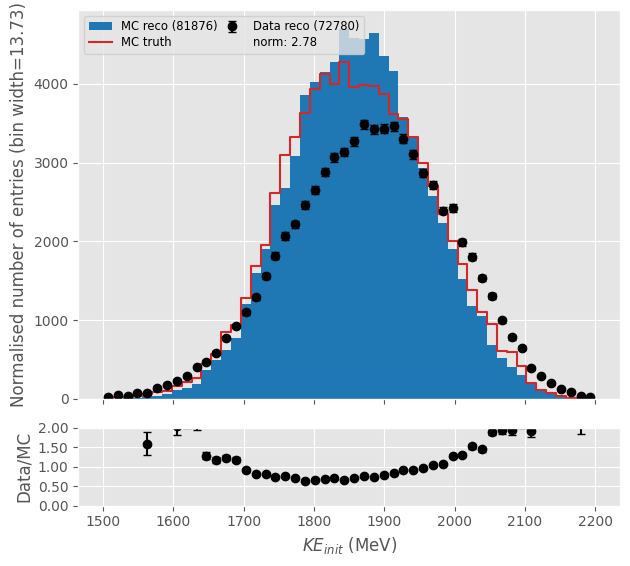

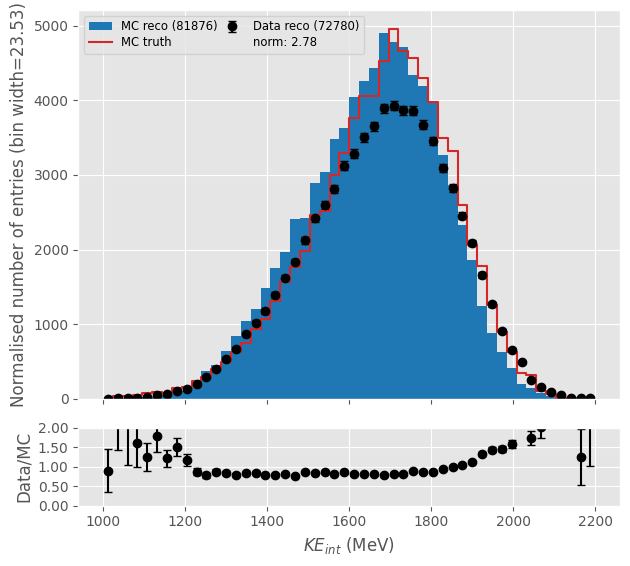

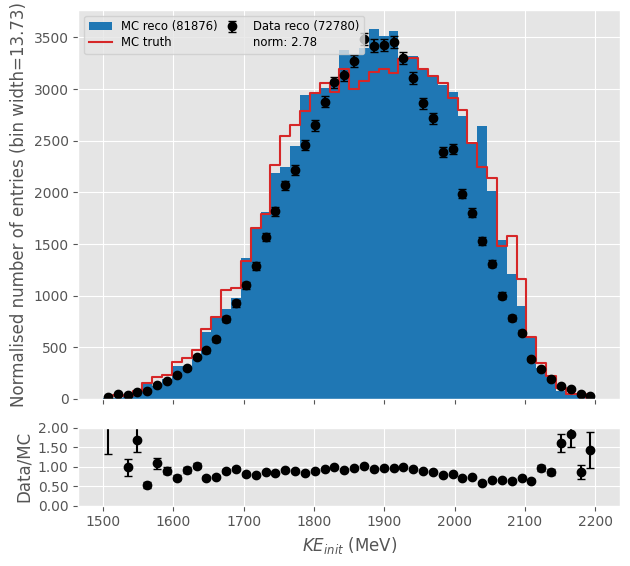

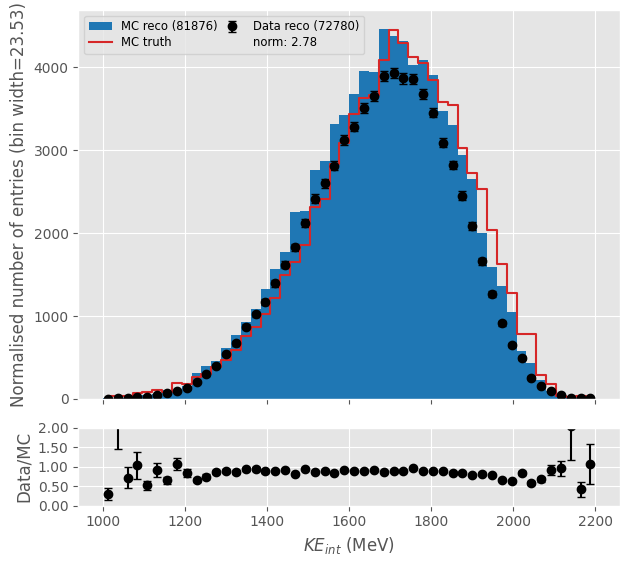

In [4]:
def PlotDataMCTruth(mc, data, truth, bins, xlabel, x_range, norm, weights, mc_label = "MC reco", data_label = "Data reco", truth_label = "MC truth"):
    Plots.PlotHistDataMC(data, mc, bins = bins, x_range = x_range, norm = norm, xlabel = xlabel, mc_labels = mc_label, data_label = data_label, mc_weights = weights)

    y, edges = np.histogram(np.array(truth), bins, range = x_range, weights = weights)
    Plots.Plot(cross_section.bin_centers(edges), args.norm * y, label = truth_label, style = "step", color = "C6", newFigure = False)

    h, l = Plots.plt.gca().get_legend_handles_labels()
    Plots.plt.legend(h + [Plots.matplotlib.patches.Rectangle((0,0), 0, 0, fill = False, edgecolor='none', visible=False)], l + [f"norm: {args.norm:.3g}"], labelspacing = 0.25,  columnspacing = 0.25, ncols = 2)
    return

PlotDataMCTruth(analysis_input_mc_s.KE_init_reco, analysis_input_data_s.KE_init_reco, analysis_input_mc_s.KE_init_true, 50, "$KE_{init}$ (MeV)", args.KE_init_range, args.norm, None)
PlotDataMCTruth(analysis_input_mc_s.KE_int_reco, analysis_input_data_s.KE_int_reco, analysis_input_mc_s.KE_int_true, 50, "$KE_{int}$ (MeV)", args.KE_int_range, args.norm, None)

with Plots.PlotBook("upstream_comparison", True) as book:
    PlotDataMCTruth(analysis_input_mc_s.KE_init_reco, analysis_input_data_s.KE_init_reco, analysis_input_mc_s.KE_init_true, 50, "$KE_{init}$ (MeV)", args.KE_init_range, args.norm, np.array(analysis_input_mc_s.weights))
    book.Save()
    PlotDataMCTruth(analysis_input_mc_s.KE_int_reco, analysis_input_data_s.KE_int_reco, analysis_input_mc_s.KE_int_true, 50, "$KE_{int}$ (MeV)", args.KE_int_range, args.norm, np.array(analysis_input_mc_s.weights))
    book.Save()


# Comparing 1GeV toy and MC

In [ ]:
def proportions(analysis_input : cross_section.AnalysisInput):
    output = {}
    output["inel"] = sum(analysis_input.exclusive_process["pion_production"]) / len(analysis_input.exclusive_process["pion_production"])
    output["charge_exchange"] = sum(analysis_input.exclusive_process["pion_production"]) / sum(analysis_input.exclusive_process["charge_exchange"])
    output["absorption"] = sum(analysis_input.exclusive_process["pion_production"]) / sum(analysis_input.exclusive_process["absorption"])
    output["single_pion_production"] = sum(analysis_input.exclusive_process["pion_production"]) / sum(analysis_input.exclusive_process["single_pion_production"])
    print(output)

proportions(cex_analyse.CreateAnalysisInput(cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_PDSP_stats.hdf5"), args, True, False))
proportions(analysis_input_toy)
proportions(analysis_input_mc)

# {s
#     'inel': 0.15439229009221384,
#     'charge_exchange': 1.0427046263345197,
#     'absorption': 0.5477174340810704,
#     'single_pion_production': 0.37737895503923263
# }

{
    'inel': 0.1506136032725508,
    'charge_exchange': 1.02520175562792,
    'absorption': 0.5234583965878696,
    'single_pion_production': 0.36955190364397267
}

{
    'inel': 0.1506136032725508,
    'charge_exchange': 1.02520175562792,
    'absorption': 0.5234583965878696,
    'single_pion_production': 0.36955190364397267
}

{
    'inel': 0.16915343548498926,
    'charge_exchange': 1.2378608757420468,
    'absorption': 0.5699301516107179,
    'single_pion_production': 0.42565033061744334
}

np.sum(counts, 1)/np.sum(counts)=array([0.28125639, 0.14577604, 0.41157754, 0.16139003])

np.sum(counts, 1)/np.sum(counts)=array([0.28981165, 0.14797511, 0.41050889, 0.15170434])

np.sum(counts, 1)/np.sum(counts)=array([0.29464939, 0.14800904, 0.41017602, 0.14716555])

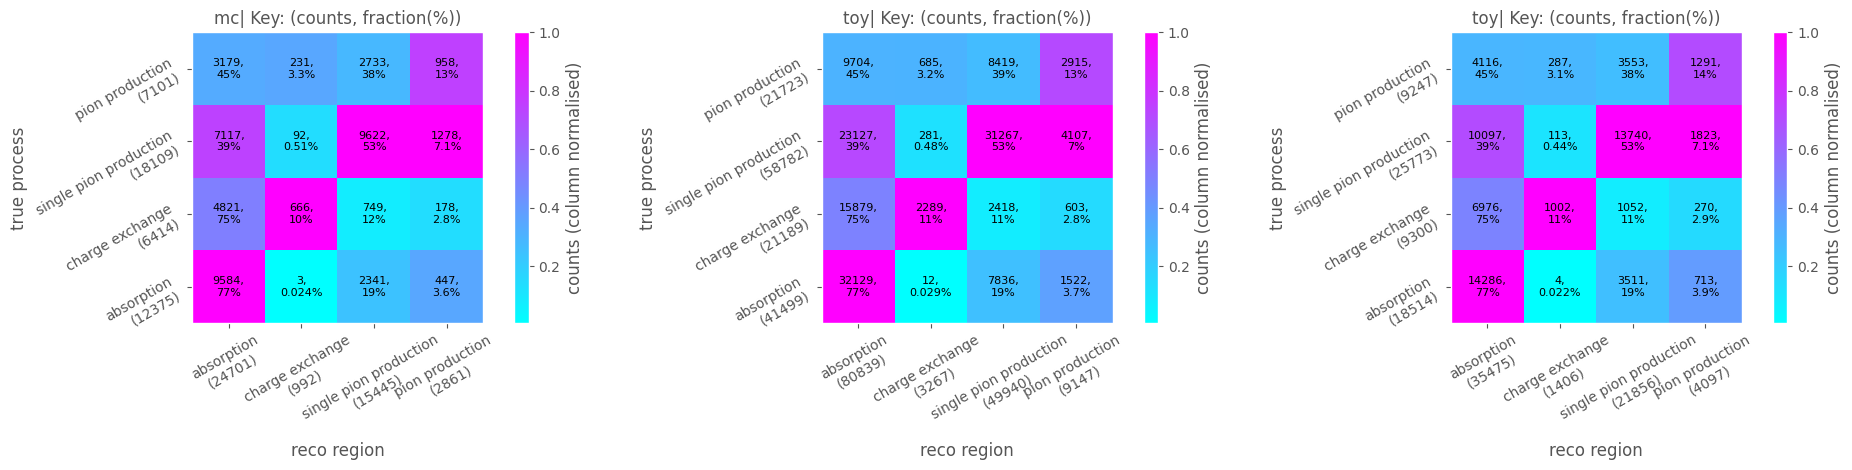

In [ ]:
plot = Plots.MultiPlot(3)
next(plot)
counts = cross_section.Toy.ComputeCounts(analysis_input_mc_s.exclusive_process, analysis_input_mc_s.regions)
print(f"{np.sum(counts, 1)/np.sum(counts)=}")
Plots.PlotConfusionMatrix(counts, list(analysis_input_mc_s.exclusive_process.keys()), list(analysis_input_mc_s.regions.keys()), "mc", newFigure = False, x_label = "true process", y_label = "reco region")
next(plot)
counts = cross_section.Toy.ComputeCounts(analysis_input_toy.exclusive_process, analysis_input_toy.regions)
print(f"{np.sum(counts, 1)/np.sum(counts)=}")
Plots.PlotConfusionMatrix(counts, list(analysis_input_toy.exclusive_process.keys()), list(analysis_input_toy.regions.keys()), "toy", newFigure = False, x_label = "true process", y_label = "reco region")

next(plot)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


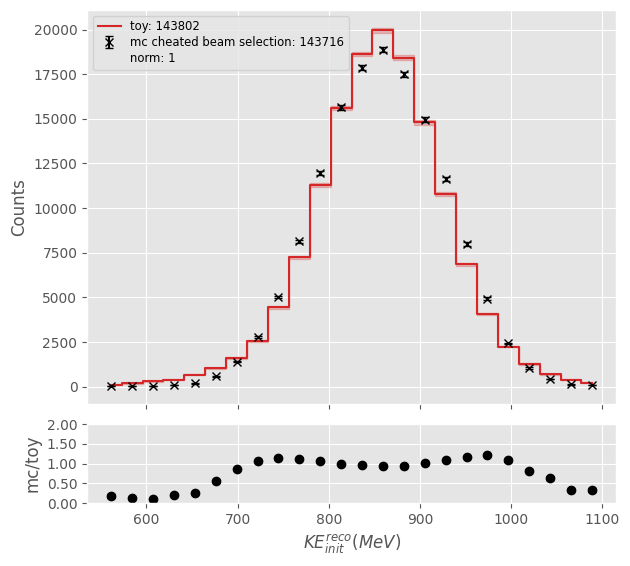

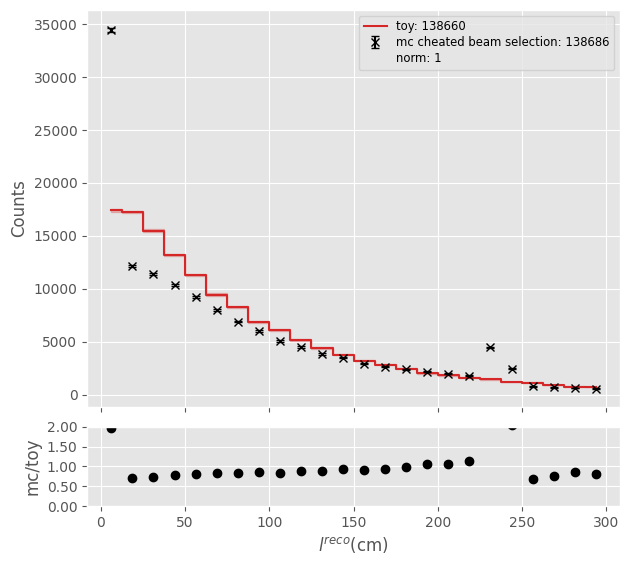

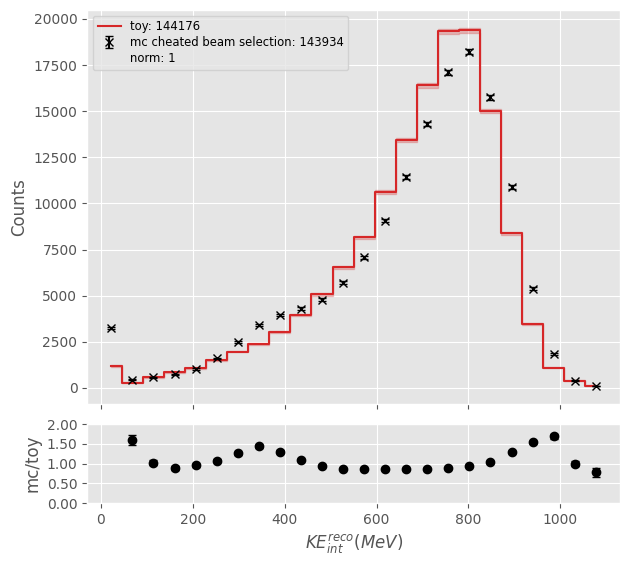

In [ ]:
with Plots.PlotBook("toy_vs_cheated_selection.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc, analysis_input_toy, "KE_init_reco", np.linspace(550, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc cheated beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc, analysis_input_toy, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}$(cm)", "mc/toy", "mc cheated beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc, analysis_input_toy, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc cheated beam selection", "toy")
    book.Save()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1592: RuntimeWarning: invalid value encountered in divide
  ratio_err = abs(ratio * np.sqrt((self.y1_err/self.y1)**2 + (self.y2_err/self.y2)**2))


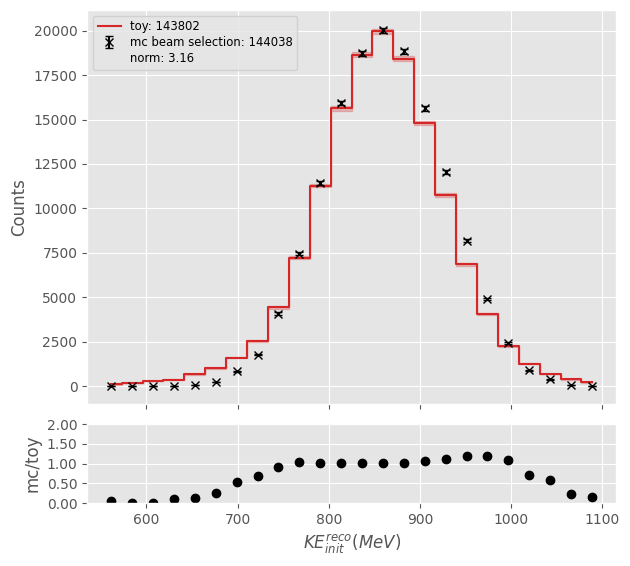

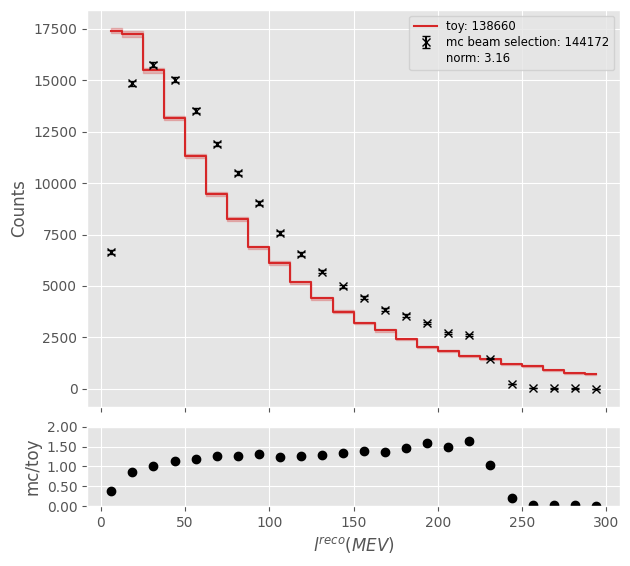

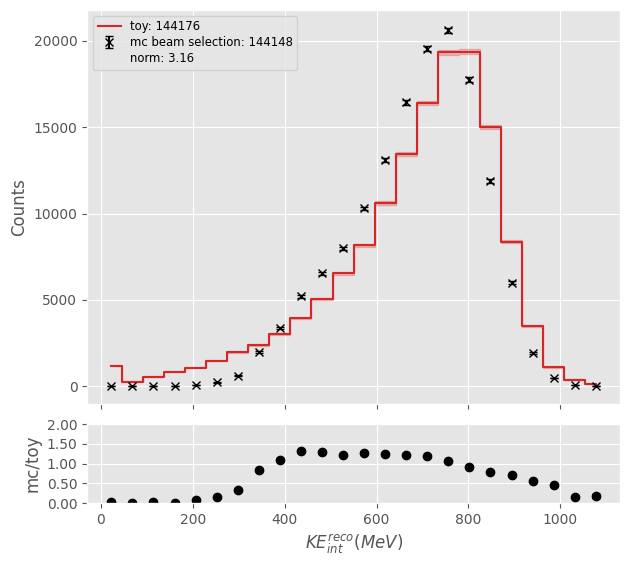

In [ ]:
with Plots.PlotBook("toy_vs_beam_selection.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy, "KE_init_reco", np.linspace(550, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}(MEV)$", "mc/toy", "mc beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc beam selection", "toy")
    book.Save()

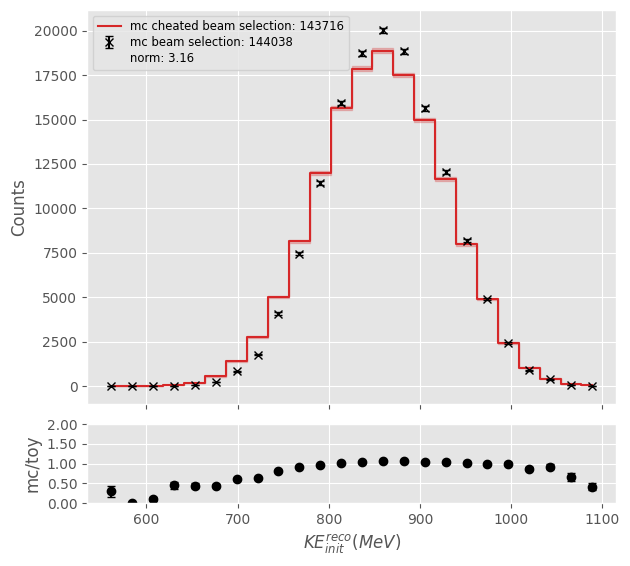

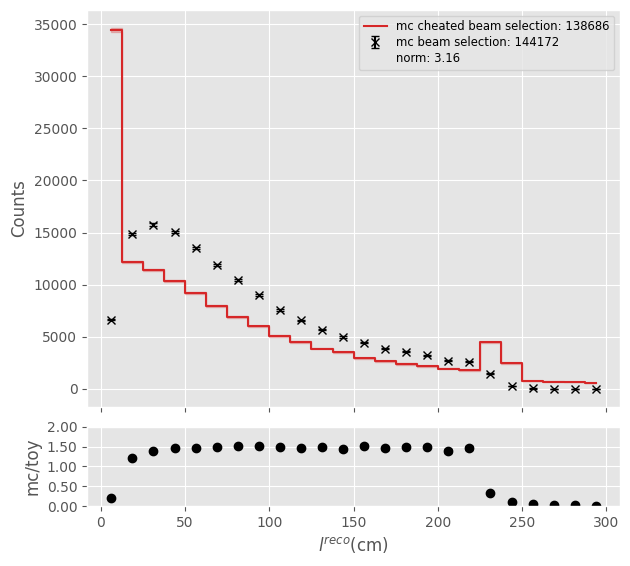

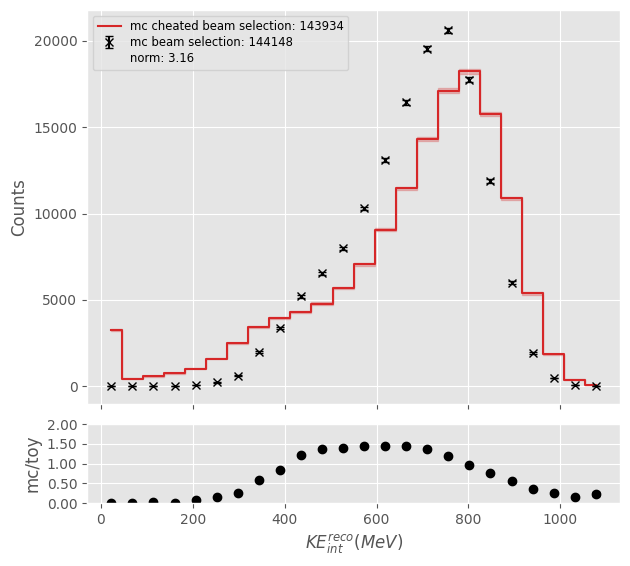

In [ ]:
with Plots.PlotBook("beam_selection_vs_cheated_selection.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_mc, "KE_init_reco", np.linspace(550, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc beam selection", "mc cheated beam selection")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_mc, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}$(cm)", "mc/toy", "mc beam selection", "mc cheated beam selection")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_mc, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc beam selection", "mc cheated beam selection")
    book.Save()

In [ ]:
print({k : sum(v) / len(v) for k, v in analysis_input_mc_s.regions.items()})
print({k : sum(v) / len(v) for k, v in analysis_input_toy.regions.items()})

{
    'absorption': 0.5419143941554595,
    'charge_exchange': 0.021763454070775103,
    'single_pion_production': 0.3388473267370176,
    'pion_production': 0.06276738114565279
}

{
    'absorption': 0.5604867225958539,
    'charge_exchange': 0.022651320807044305,
    'single_pion_production': 0.34625251334673784,
    'pion_production': 0.06341953823753727
}

 - alter the proportion of processes in toy to match MC, redo fit

 - perfect reweight of toy template?
 - selection efficiency weights per exclusive process

# Efficiency Weights

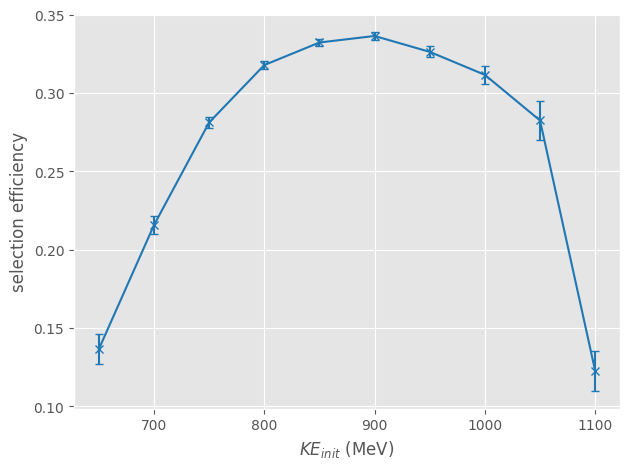

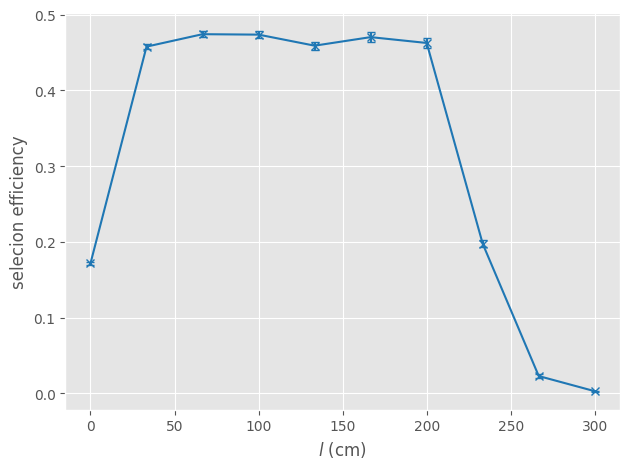

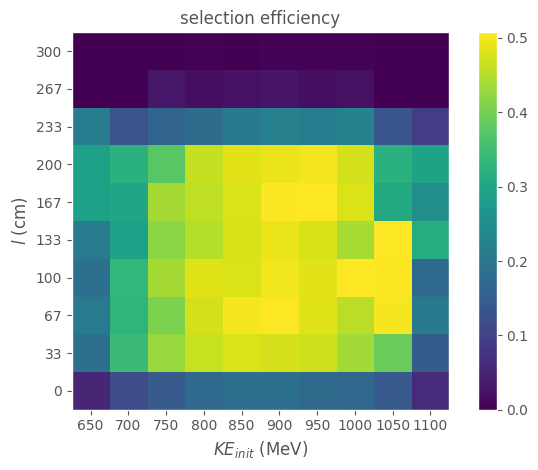

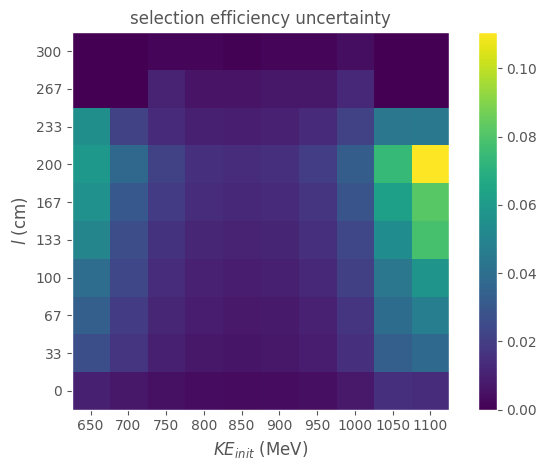

In [ ]:
def MakeMatrix(analysis_input : cross_section.AnalysisInput, bins : int, x_range, y_range, process : str = None):
    
    l = analysis_input.track_length_reco[analysis_input.exclusive_process[process]] if process is not None else analysis_input.track_length_reco
    e = analysis_input.KE_init_reco[analysis_input.exclusive_process[process]] if process is not None else analysis_input.KE_init_reco

    x = np.array(np.clip(l, min(x_range), max(x_range)))
    y = np.array(np.clip(e, min(y_range), max(y_range)))
    return np.histogram2d(x, y, bins = bins, range = [x_range, y_range])[0]

def EfficiencyMatrix(data_selected, data_cheated, bins : int, track_length_range = [0, 300], KE_init_range = [650, 1100], process : str = None, book : Plots.PlotBook = None):
    h_selected = MakeMatrix(data_selected, bins, track_length_range, KE_init_range, process)
    h_cheated = MakeMatrix(data_cheated, bins, track_length_range, KE_init_range, process)
    # fractions = h_selected / h_cheated

    fractions, errors = cex_toy_parameters.Efficiency(h_selected, h_cheated)

    fractions = np.where(np.isnan(fractions), 0, fractions)
    fractions = np.where(abs(fractions) == np.inf, 0, fractions)

    bins_KE = np.linspace(*KE_init_range, bins)
    bins_trklen = np.linspace(*track_length_range, bins)

    f, e = cex_toy_parameters.Efficiency(np.sum(h_selected, 0), np.sum(h_cheated, 0))
    Plots.Plot(bins_KE, f, yerr = e, marker = "x", xlabel = "$KE_{init}$ (MeV)", ylabel = "selection efficiency")
    if book is not None: book.Save()

    f, e = cex_toy_parameters.Efficiency(np.sum(h_selected, 1), np.sum(h_cheated, 1))
    Plots.Plot(bins_trklen, f, yerr = e, marker = "x", xlabel = "$l$ (cm)", ylabel = "selecion efficiency")
    if book is not None: book.Save()

    KE_ticks = [f"{i:.0f}" for i in bins_KE]
    trklen_ticks = [f"{i:.0f}" for i in bins_trklen]

    Plots.plt.figure()
    Plots.plt.imshow(fractions, origin = "lower") #extent = (650, 1100, 0, 300), aspect = (1100 - 650)/(300 - 0))
    Plots.plt.colorbar()

    Plots.plt.gca().set_xticks(np.arange(len(bins_KE)), labels=KE_ticks)
    Plots.plt.gca().set_yticks(np.arange(len(bins_trklen)), labels=trklen_ticks)
    Plots.plt.xlabel("$KE_{init}$ (MeV)")
    Plots.plt.ylabel("$l$ (cm)")
    Plots.plt.grid(False)
    Plots.plt.title("selection efficiency")
    Plots.plt.tight_layout()
    if book is not None: book.Save()

    Plots.plt.figure()
    Plots.plt.imshow(errors, origin = "lower") #extent = (650, 1100, 0, 300), aspect = (1100 - 650)/(300 - 0))
    Plots.plt.colorbar()

    Plots.plt.gca().set_xticks(np.arange(len(bins_KE)), labels=KE_ticks)
    Plots.plt.gca().set_yticks(np.arange(len(bins_trklen)), labels=trklen_ticks)
    Plots.plt.xlabel("$KE_{init}$ (MeV)")
    Plots.plt.ylabel("$l$ (cm)")
    Plots.plt.grid(False)
    Plots.plt.title("selection efficiency uncertainty")
    Plots.plt.tight_layout()
    if book is not None: book.Save()


    return fractions

fractions = EfficiencyMatrix(analysis_input_mc_s, analysis_input_mc, 10)

In [ ]:
def CreateWeights(KE_init_reco, track_length_reco, weights_matrix, bins):
    column_ind = np.digitize(np.clip(KE_init_reco, 650, 1100), np.linspace(650, 1100, bins)) - 1
    row_ind = np.digitize(np.clip(track_length_reco, 0, 300), np.linspace(0, 300, bins)) - 1
    toy_weights = weights_matrix.flatten()[(row_ind * bins) + column_ind]
    return toy_weights

toy_weights = CreateWeights(analysis_input_toy_template.KE_init_reco, analysis_input_toy_template.track_length_reco, fractions, 10)

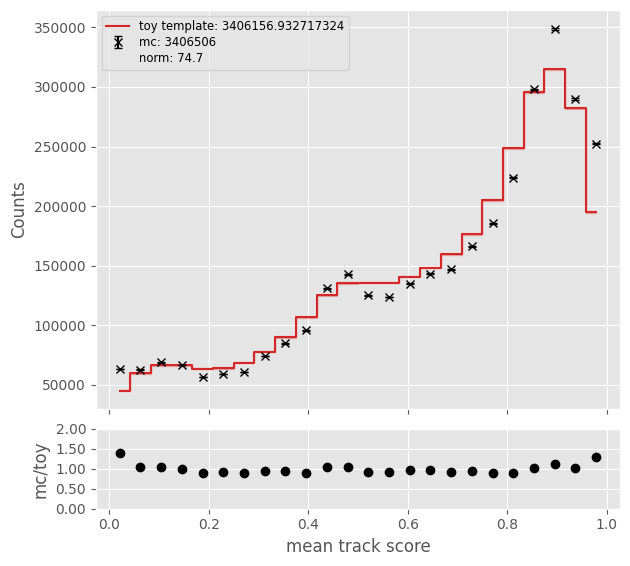

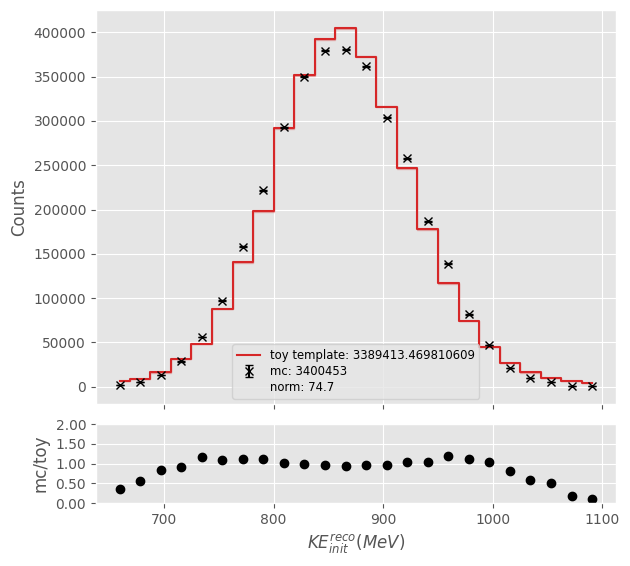

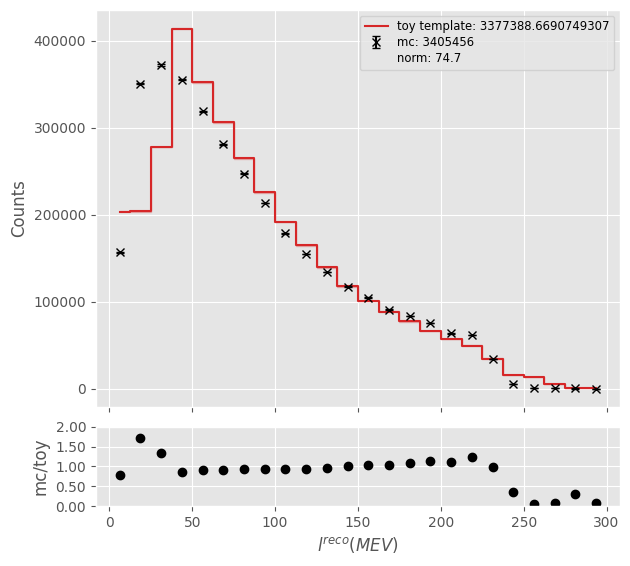

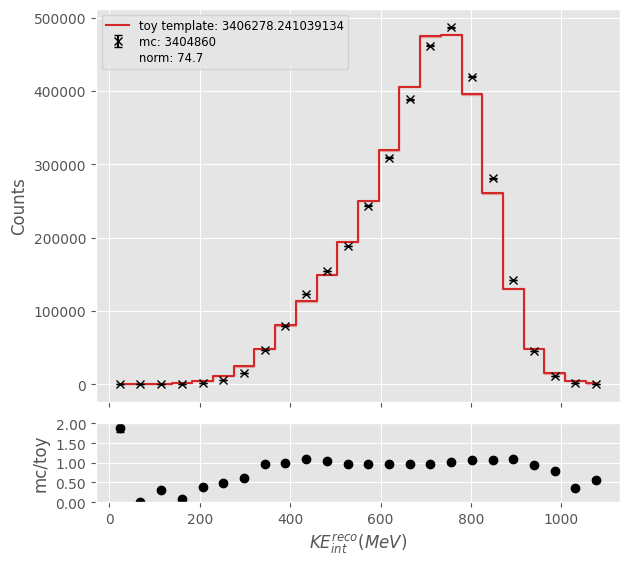

In [ ]:
with Plots.PlotBook("ratio_plot_weighted.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "mean_track_score", np.linspace(0, 1, 25), "mean track score", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "KE_init_reco", np.linspace(650, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}(MEV)$", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()


# Region Fit

## MC template

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 11, 'channel_1': 11, 'channel_2': 11, 'channel_3': 11, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mean_track_score_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mean_track_score_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 64
   auxdata: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

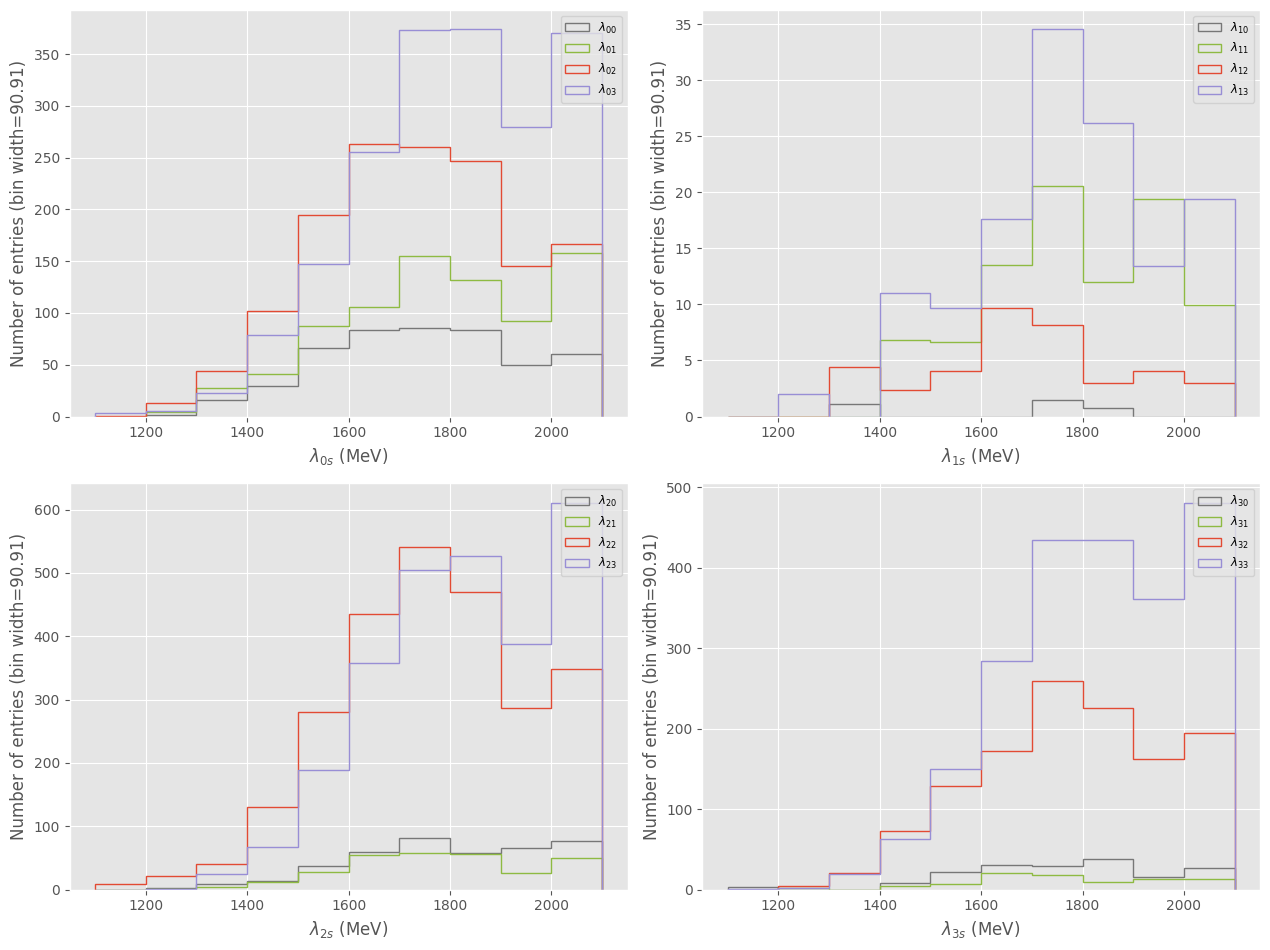

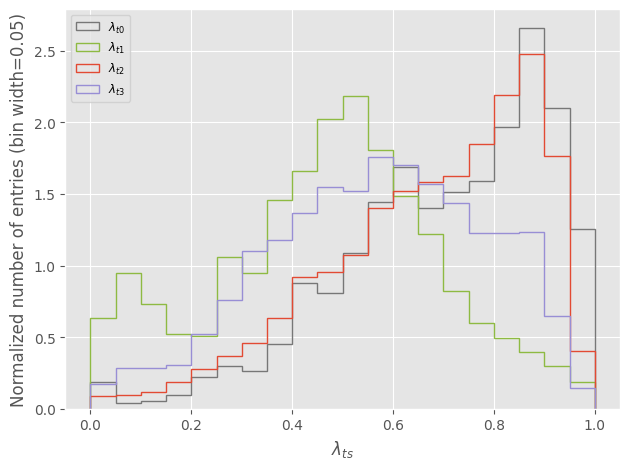

In [ ]:
analysis_input_mc_split = cross_section.AnalysisInput.CreateTrainTestSamples(analysis_input_mc_s, 1, 0.5)
model, templates_energy, templates_mean_track_score = cross_section.RegionFit.CreateModel(analysis_input_mc_split["train"], args.energy_slices, mean_track_score_bins, True)

tags = cross_section.Tags.ExclusiveProcessTags(analysis_input_mc_split["train"].exclusive_process)
for j, c in Plots.IterMultiPlot(templates_energy):
    for i, s in enumerate(c):
        Plots.PlotHist(args.energy_slices.pos_overflow, args.energy_slices.pos_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{{j}{i}}}$", xlabel = f"$\lambda_{{{j}s}}$ (MeV)", histtype = "step", newFigure = False, density = False)

Plots.plt.figure()
for i, s in enumerate(templates_mean_track_score):
    Plots.PlotHist(cross_section.bin_centers(mean_track_score_bins), mean_track_score_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{t{i}}}$", xlabel = f"$\lambda_{{ts}}$", histtype = "step", newFigure = False, density = True)
Plots.plt.legend(loc = "upper left")

In [ ]:
def RegionFitMC(fit_input : cross_section.AnalysisInput, energy_slice : cross_section.Slices, mean_track_score_bins : np.array, template : cross_section.AnalysisInput, suggest_init : bool = False) -> cross_section.cabinetry.model_utils.ModelPrediction:

    print(f"{template.weights=}")
    print(f"{fit_input.weights=}")
    model = cross_section.RegionFit.CreateModel(template, energy_slice, mean_track_score_bins, False, mc_stat_unc = True, pad = True)

    observed = cross_section.RegionFit.GenerateObservations(fit_input, energy_slice, mean_track_score_bins, model)

    if suggest_init is True:
        init_params = cex_analyse.CreateInitParams(model, fit_input, energy_slice, mean_track_score_bins)
    else:
        init_params = None
    result = cross_section.RegionFit.Fit(observed, model, init_params, verbose = True)
    return cross_section.cabinetry.model_utils.prediction(model, fit_results = result)

template size 14726, data size 14726

template.weights=None

fit_input.weights=None

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 11, 'channel_1': 11, 'channel_2': 11, 'channel_3': 11}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 44
   auxdata: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_yield_KE, sum(total_yield_KE)=(array([ 709.92014426,  999.92558823, 4574.72839759, 4367.82782941]), 
10652.401959497838)

actual_yield_KE, sum(actual_yield_KE)=([1081, 1363, 5224, 6649], 14317)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


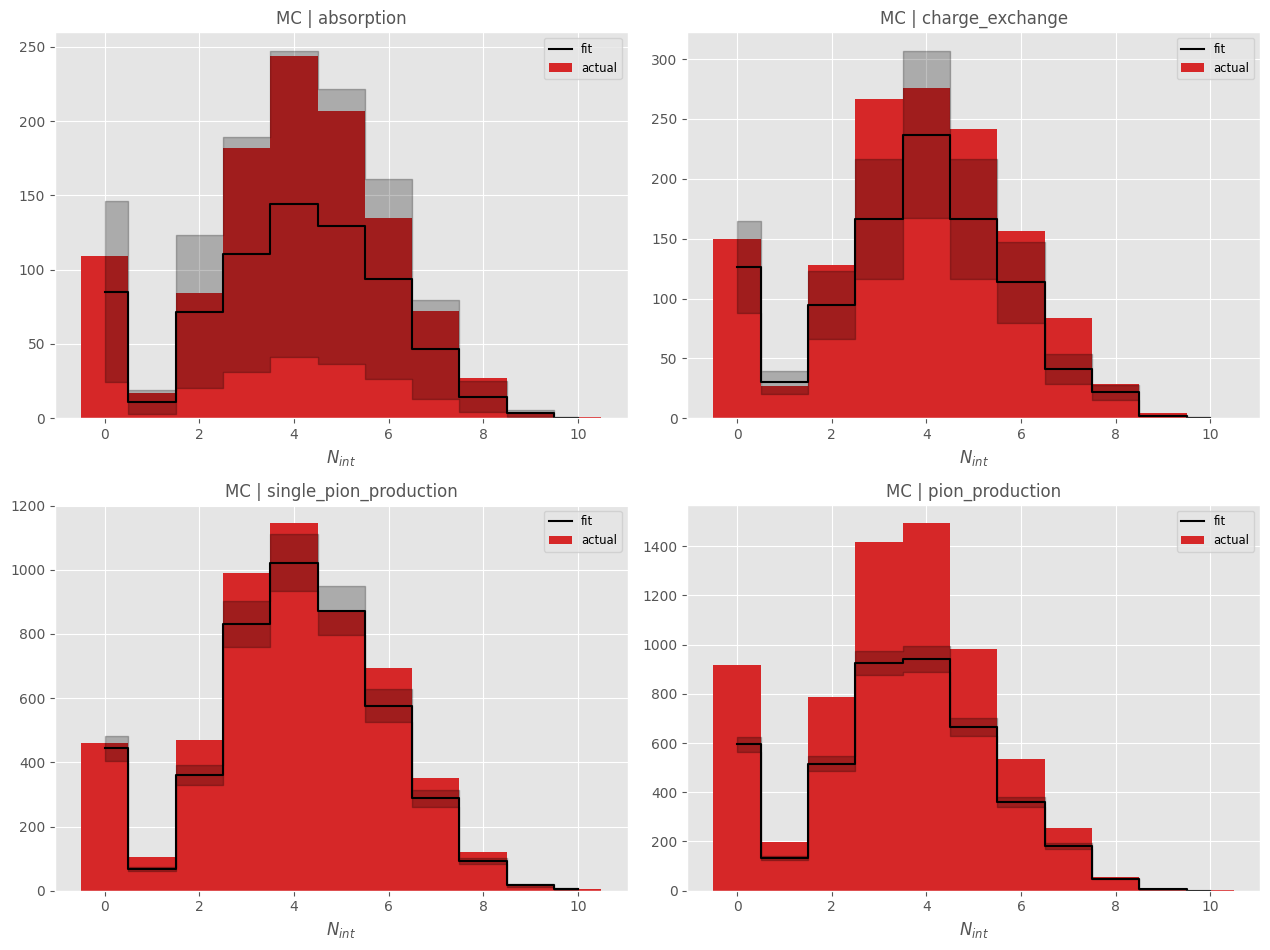

In [ ]:
import dataclasses

def FitStudyMC(mc_sample = cross_section.AnalysisInput, seed : int = 1, train_fraction : float = 0.5, book : Plots.PlotBook = Plots.PlotBook.null):
    train, test = cross_section.AnalysisInput.CreateTrainTestSamples(mc_sample, seed, train_fraction).values()
    print(f"template size {len(train.KE_init_true)}, data size {len(test.KE_init_true)}")
    region_fit_result = RegionFitMC(test, args.energy_slices, None, train, False)
    CompareFitResults(region_fit_result, test, args.energy_slices, None, book)
    return

ai_no_weights = dataclasses.replace(analysis_input_mc_s)
ai_no_weights.weights = None

book = Plots.PlotBook("mc_region_fit_mc_template.pdf", False)
FitStudyMC(ai_no_weights, 12, 0.5, book)
book.close()

In [ ]:
RegionFitMC(ai_no_weights, args.energy_slices, None, ai_no_weights, False)

template.weights=None

fit_input.weights=None

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 11, 'channel_1': 11, 'channel_2': 11, 'channel_3': 11}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 44
   auxdata: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

ModelPrediction(model=<pyhf.pdf.Model object at 0x7f7b2e6d98d0>, model_yields=[[[115.45007255313581, 10.08751110515581, 84.06560040116385, 181.58174911528457, 217.449749180771, 215.20800859452496, 153.55990717483087, 81.8239118801591, 30.263884977553595, 1.1258382827268072, 1.1170184779922205], [197.64459713054075, 36.93227082313641, 150.72898480579985, 306.4490837770619, 338.3916596586581, 265.52267080543595, 191.65549413690994, 85.84571078812074, 43.92141883767699, 5.013127931278428, 0.994771028510801], [209.58688748495004, 40.41217561372338, 194.54929472290786, 470.86581981762765, 552.6329388396776, 523.4975516774026, 401.31686261282016, 206.7675200708277, 71.42936106958138, 12.272177386119775, 1.8732365052086168], [487.4564320601647, 85.12449450401763, 407.39608600410526, 769.1883538587128, 837.0877219885484, 582.7184760035924, 345.57745046261505, 188.49683662673954, 43.577580377303725, 6.107465270237197, 3.029809727264288]], [[1.120535622232413, 1.1167002820985284e-10, 1.118604494

## Nll scan

In [ ]:
def NllScan(param : str, fit_input : cross_section.AnalysisInput, energy_slice : cross_section.Slices, mean_track_score_bins, template : cross_section.AnalysisInput, suggest_init : bool = True) -> cross_section.cabinetry.model_utils.ModelPrediction:
    model = cross_section.RegionFit.CreateModel(template, energy_slice, mean_track_score_bins, False, mc_stat_unc = False)

    observed = cross_section.RegionFit.GenerateObservations(fit_input, energy_slice, mean_track_score_bins, model)

    if suggest_init is True:
        init_params = cex_analyse.CreateInitParams(model, fit_input, energy_slice, mean_track_score_bins)
    else:
        init_params = None

    return cross_section.cabinetry.fit.scan(model, observed, param, par_range = None, init_pars = init_params, par_bounds = [[0, np.inf]]*model.config.npars, custom_fit = True, tolerance = 0.001)

In [ ]:
train, test = cross_section.AnalysisInput.CreateTrainTestSamples(analysis_input_mc_s, 12, 0.5).values()
for i in range(4):
    print(f"mu_{i}")
    region_fit_result = NllScan(f"mu_{i}", analysis_input_mc_s, args.energy_slices, None, analysis_input_mc_s, True)
    cross_section.cabinetry.visualize.scan(region_fit_result, figure_folder = "test/figures/")

mu_0

NameError: name 'NllScan' is not defined

## toy template

In [ ]:
def FitStudy(analysis_input, template_input : cross_section.AnalysisInput, book : Plots.PlotBook, template_weights : bool = None):
    region_fit_result = cex_analyse.RegionFit(analysis_input, args.energy_slices, mean_track_score_bins, template_input, suggest_init = False, beam_selection = False, template_weights = template_weights)
    # 6333.982696725586 # looked OK
    # 6248.008381092954 # looks bad
    CompareFitResults(region_fit_result, analysis_input, book)
    return region_fit_result

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 23, 'channel_1': 23, 'channel_2': 23, 'channel_3': 23, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mean_track_sco

total_yield_KE, sum(total_yield_KE)=(array([13440.95898754,  6368.02436649, 18164.54053341,  6808.6293573 ]), 
44782.153244744906)

actual_yield_KE, sum(actual_yield_KE)=([12375, 6414, 18109, 7101], 43999)

total_yield_score, sum(total_yield_score)=(array([13453.87329984,  6368.89251538, 18168.55744694,  6806.55538732]),
44797.87864948841)

actual_yield_score, sum(actual_yield_score)=([12375, 6414, 18109, 7101], 43999)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


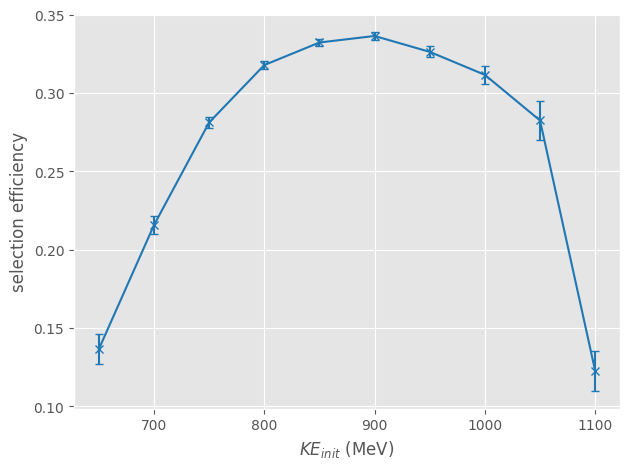

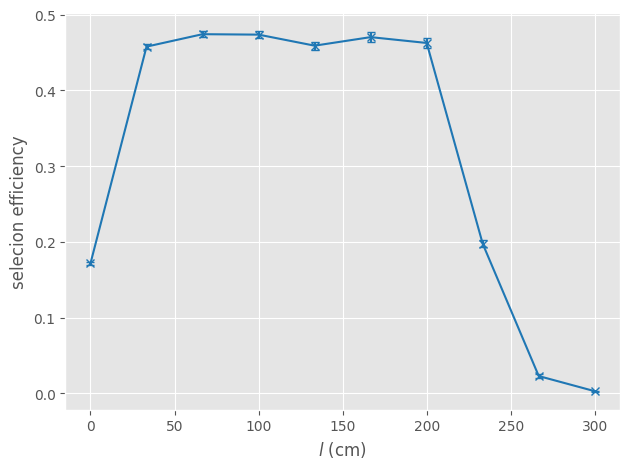

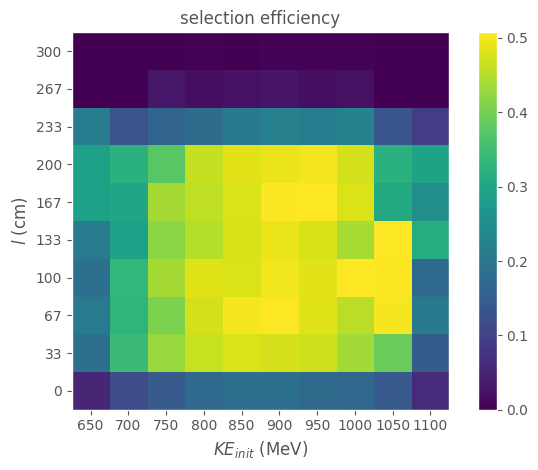

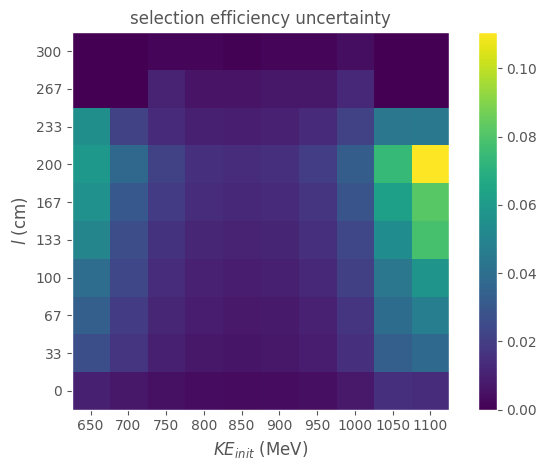

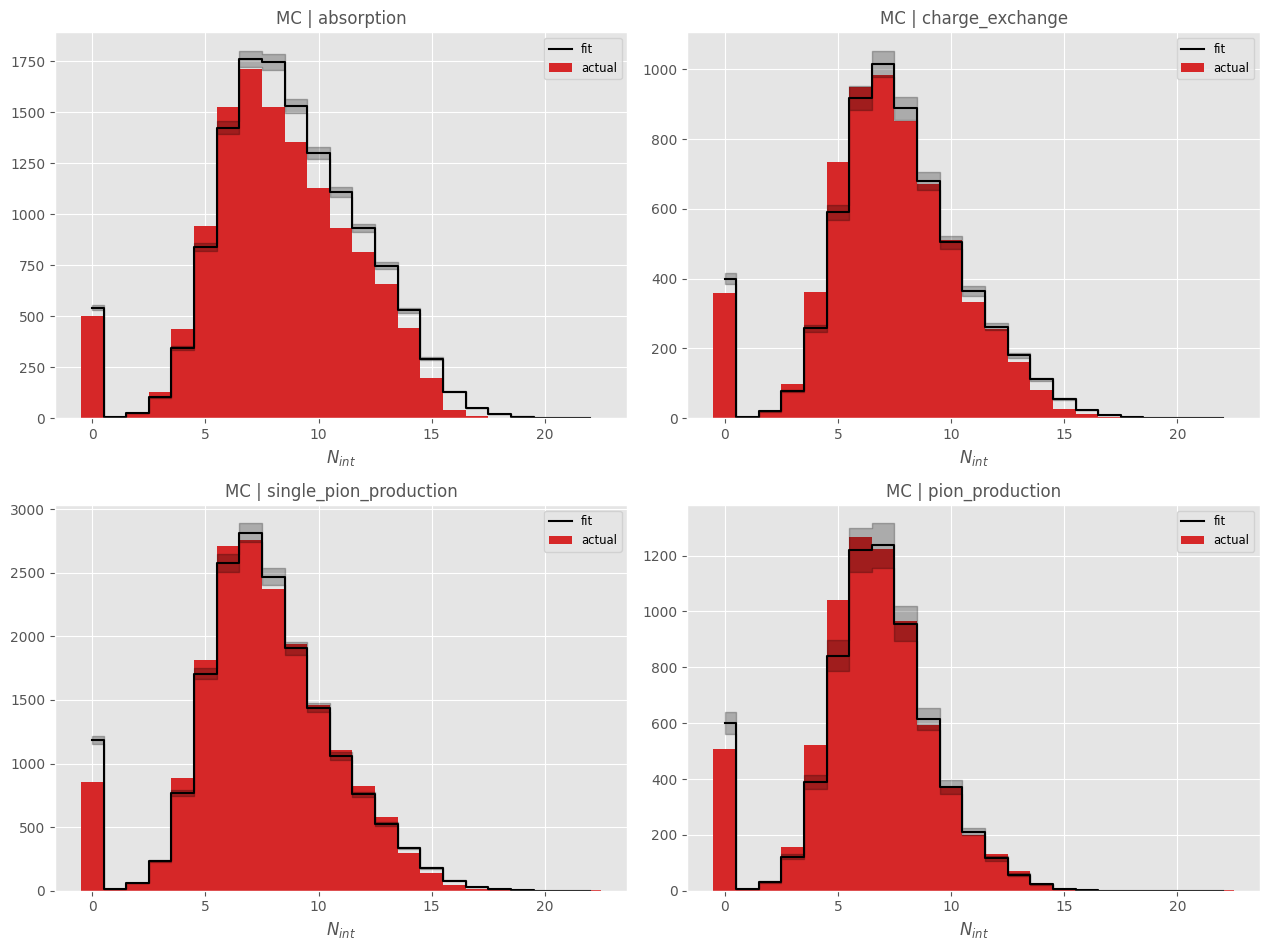

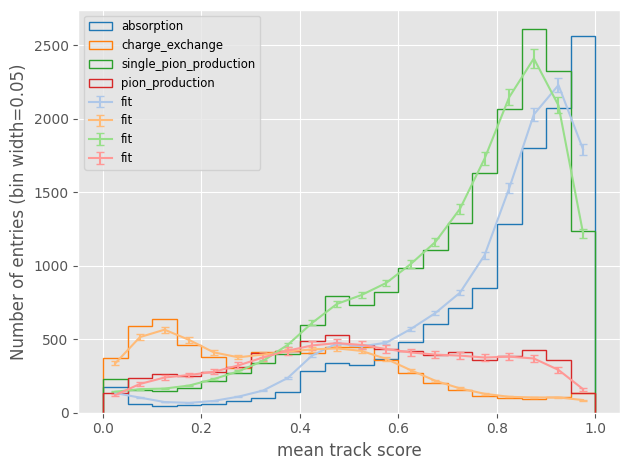

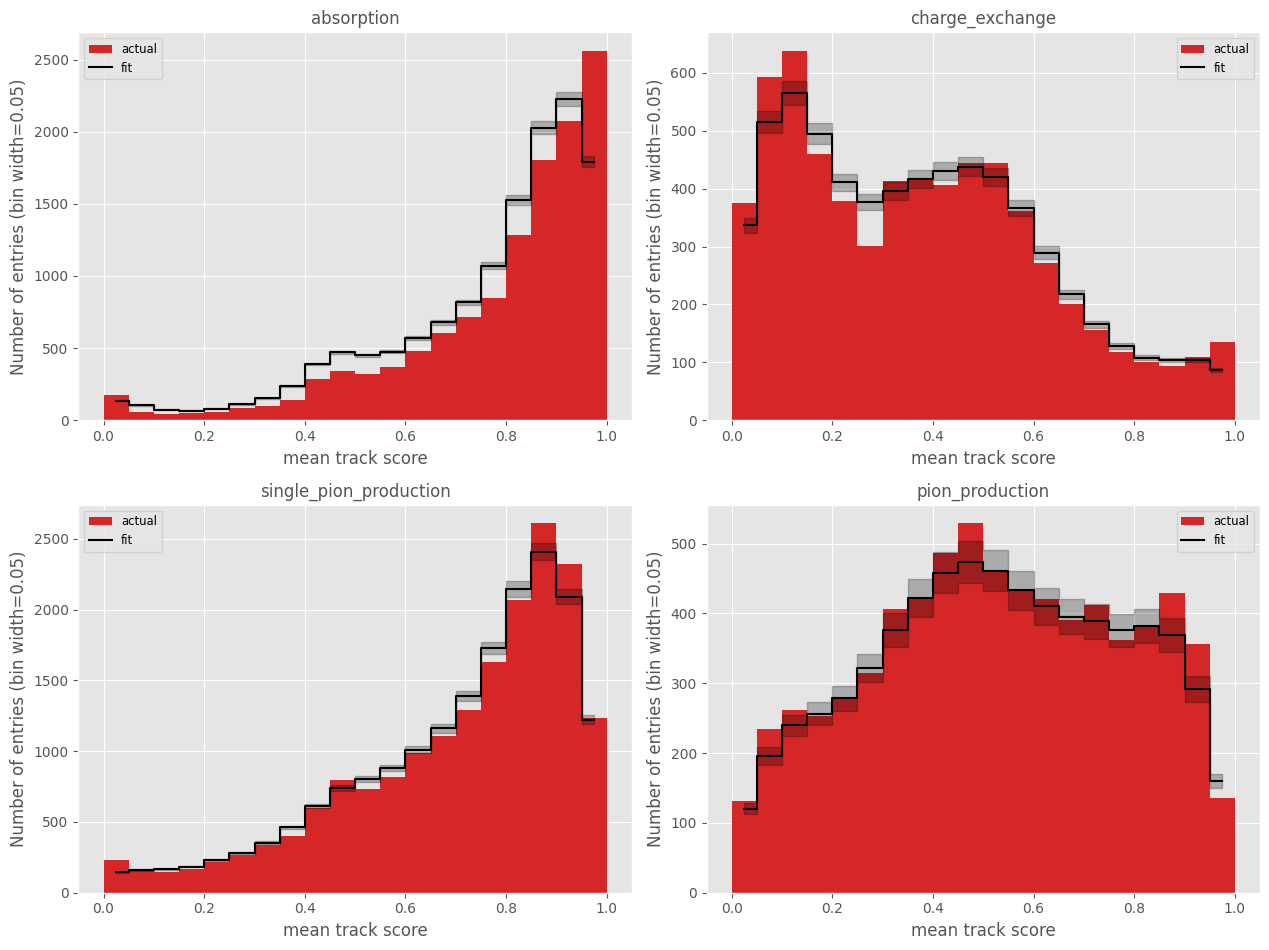

In [ ]:
book = Plots.PlotBook("mc_region_fit_toy_template_unweighted.pdf", False)
fractions = EfficiencyMatrix(analysis_input_mc_s, analysis_input_mc, 10, book = book)
template_weights = CreateWeights(analysis_input_toy_template.KE_init_reco, analysis_input_toy_template.track_length_reco, fractions, 10)
FitStudy(analysis_input_mc_s, analysis_input_toy_template, book, template_weights)
book.close()

# data Analysis

sum(weights)=45581.0000000001

len(weights)=45581

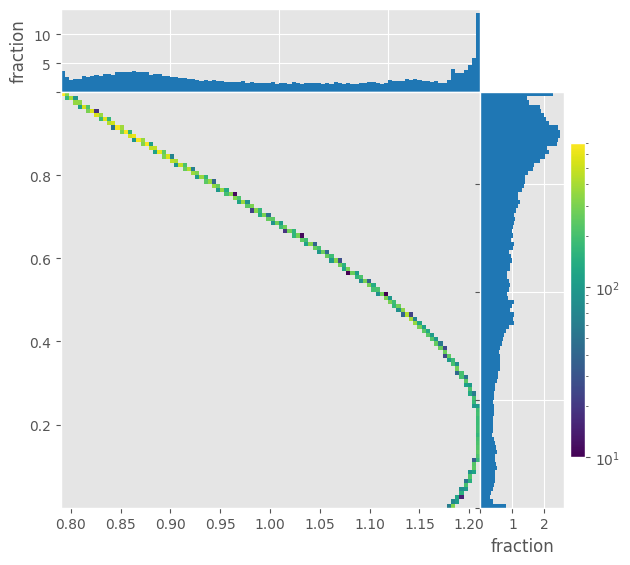

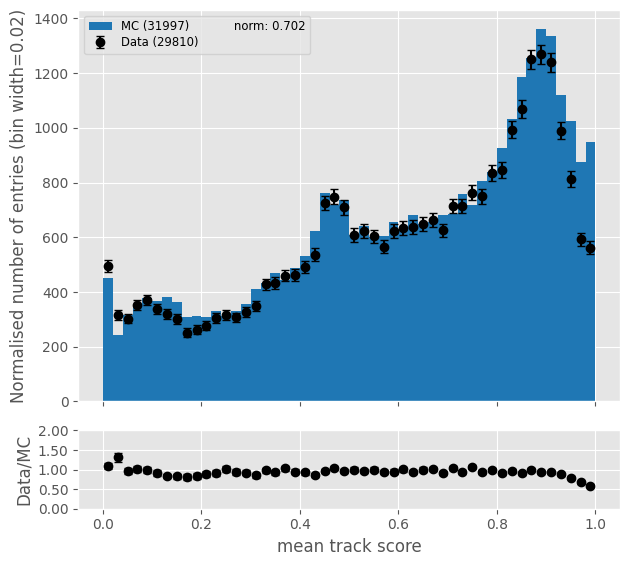

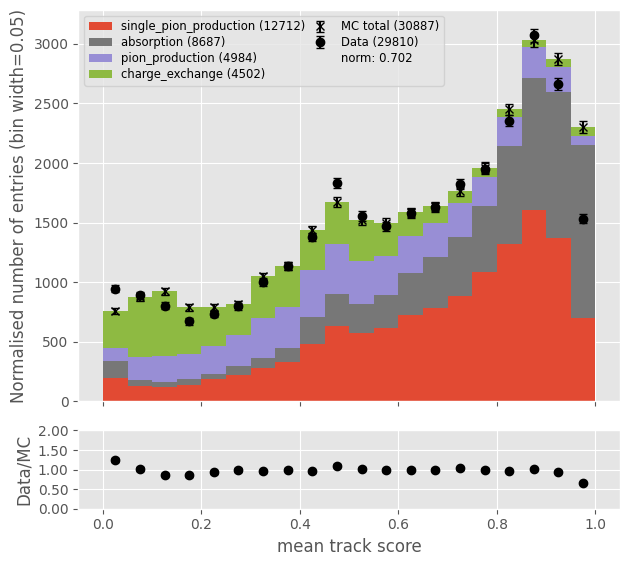

In [ ]:
class Line(cross_section.Fitting.FitFunction):
    n_params = 2

    def __new__(cls, x, p0, p1) -> np.array:
        return cls.func(x, p0, p1)

    def func(x, p0, p1):
        return p0 * x + p1

class Asym(cross_section.Fitting.FitFunction):
    n_params = 3

    def __new__(cls, x, p0, p1, p2) -> np.array:
        return cls.func(x, p0, p1, p2)

    def func(x, p0, p1, p2):
        return 1/(p0*(x**p2) + p1)

def MeanTrackScoreWeights(mean_track_score, func : cross_section.Fitting.FitFunction, params : list, truncate : int = 10):
    weights = 1/func(mean_track_score, *params)
    weights = np.where(weights > truncate, truncate, weights)
    return np.array(weights)

mean_track_score_weight_params = cross_section.LoadConfiguration("test/1GeV_track_score_reweight_params.json")

weights = MeanTrackScoreWeights(analysis_input_mc_s.mean_track_score, cross_section.Fitting.poly2d, [v["value"] for v in mean_track_score_weight_params.values()])

scale = sum(weights) / len(weights)
weights = weights/scale 

print(f"{sum(weights)=}")
print(f"{len(weights)=}")

Plots.PlotHist2DMarginal(weights, analysis_input_mc_s.mean_track_score)

Plots.PlotHistDataMC(analysis_input_data_s.mean_track_score, analysis_input_mc_s.mean_track_score, 50, x_range = [0, 1], norm = args.norm, xlabel = "mean track score", mc_weights = weights)
# book.Save()

Plots.PlotTagged(analysis_input_mc_s.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(analysis_input_mc_s.exclusive_process), data2 = analysis_input_data_s.mean_track_score, bins = mean_track_score_bins, norm = args.norm, x_label = "mean track score", data_weights = weights)
# book.Save()

In [8]:
book = Plots.PlotBook("1GeV_data_region_fit.pdf", False)

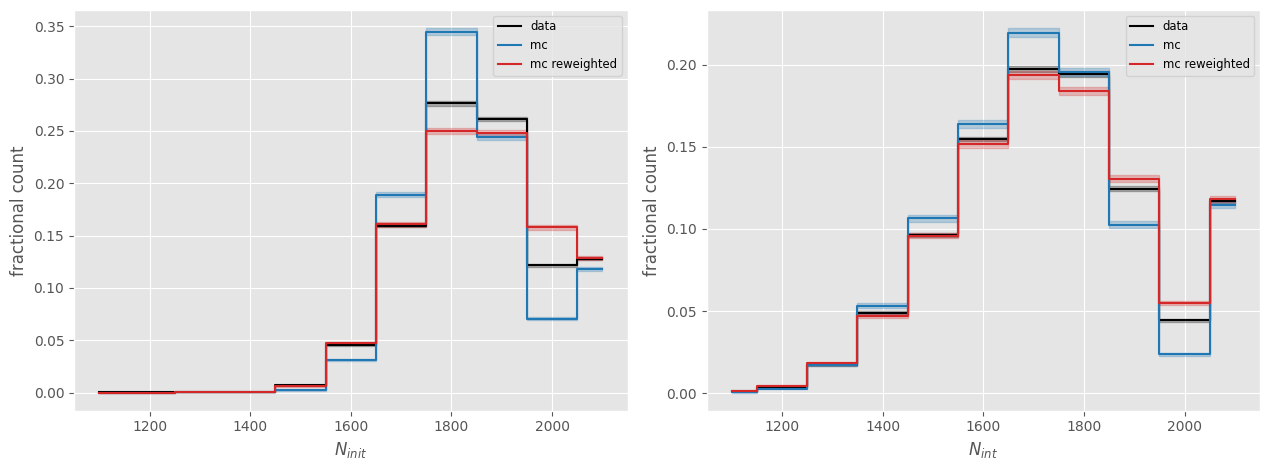

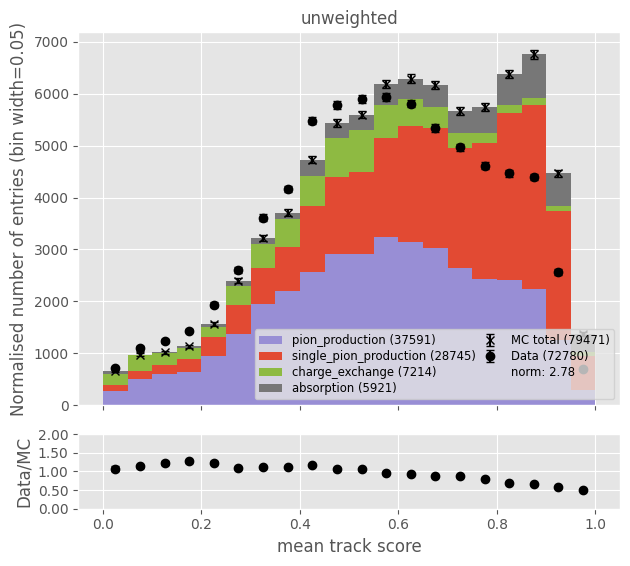

In [9]:
hist_labels = ["$N_{init}$", "$N_{int}$", "$N_{int, ex}$", "$N_{inc}$"]
hists_mc = cross_section.EnergySlice.CountingExperiment(analysis_input_mc_s.KE_int_reco, analysis_input_mc_s.KE_init_reco, analysis_input_mc_s.outside_tpc_reco, analysis_input_mc_s.exclusive_process[args.signal_process], args.energy_slices, False, analysis_input_mc_s.weights)
hists_mc_no_rw = cross_section.EnergySlice.CountingExperiment(analysis_input_mc_s.KE_int_reco, analysis_input_mc_s.KE_init_reco, analysis_input_mc_s.outside_tpc_reco, analysis_input_mc_s.exclusive_process[args.signal_process], args.energy_slices, False)
hists_data = cross_section.EnergySlice.CountingExperiment(analysis_input_data_s.KE_int_reco, analysis_input_data_s.KE_init_reco, analysis_input_data_s.outside_tpc_reco, analysis_input_data_s.regions[args.signal_process], args.energy_slices, False)

for i in Plots.MultiPlot(2):
    Plots.Plot(args.energy_slices.pos_overflow, hists_data[i] / sum(hists_data[i]), yerr = np.sqrt(hists_data[i]) / sum(hists_data[i]), label = "data", xlabel = hist_labels[i], newFigure = False, style = "step", color = "k", ylabel = "fractional count")
    Plots.Plot(args.energy_slices.pos_overflow, hists_mc_no_rw[i] / sum(hists_mc_no_rw[i]), yerr = np.sqrt(hists_mc_no_rw[i]) / sum(hists_mc_no_rw[i]), label = "mc", newFigure = False, style = "step", color = "C0")
    Plots.Plot(args.energy_slices.pos_overflow, hists_mc[i] / sum(hists_mc[i]), yerr = np.sqrt(hists_mc[i]) / sum(hists_mc[i]), label = "mc reweighted", newFigure = False, style = "step", color = "C6")
book.Save()

# Plots.PlotTagged(analysis_input_mc_s.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(analysis_input_mc_s.exclusive_process), data2 = analysis_input_data_s.mean_track_score, bins = mean_track_score_bins, norm = args.norm, x_label = "mean track score", data_weights = weights, title = "weighted")
# book.Save()

Plots.PlotTagged(analysis_input_mc_s.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(analysis_input_mc_s.exclusive_process), data2 = analysis_input_data_s.mean_track_score, bins = mean_track_score_bins, norm = args.norm, x_label = "mean track score", title = "unweighted")
book.Save()


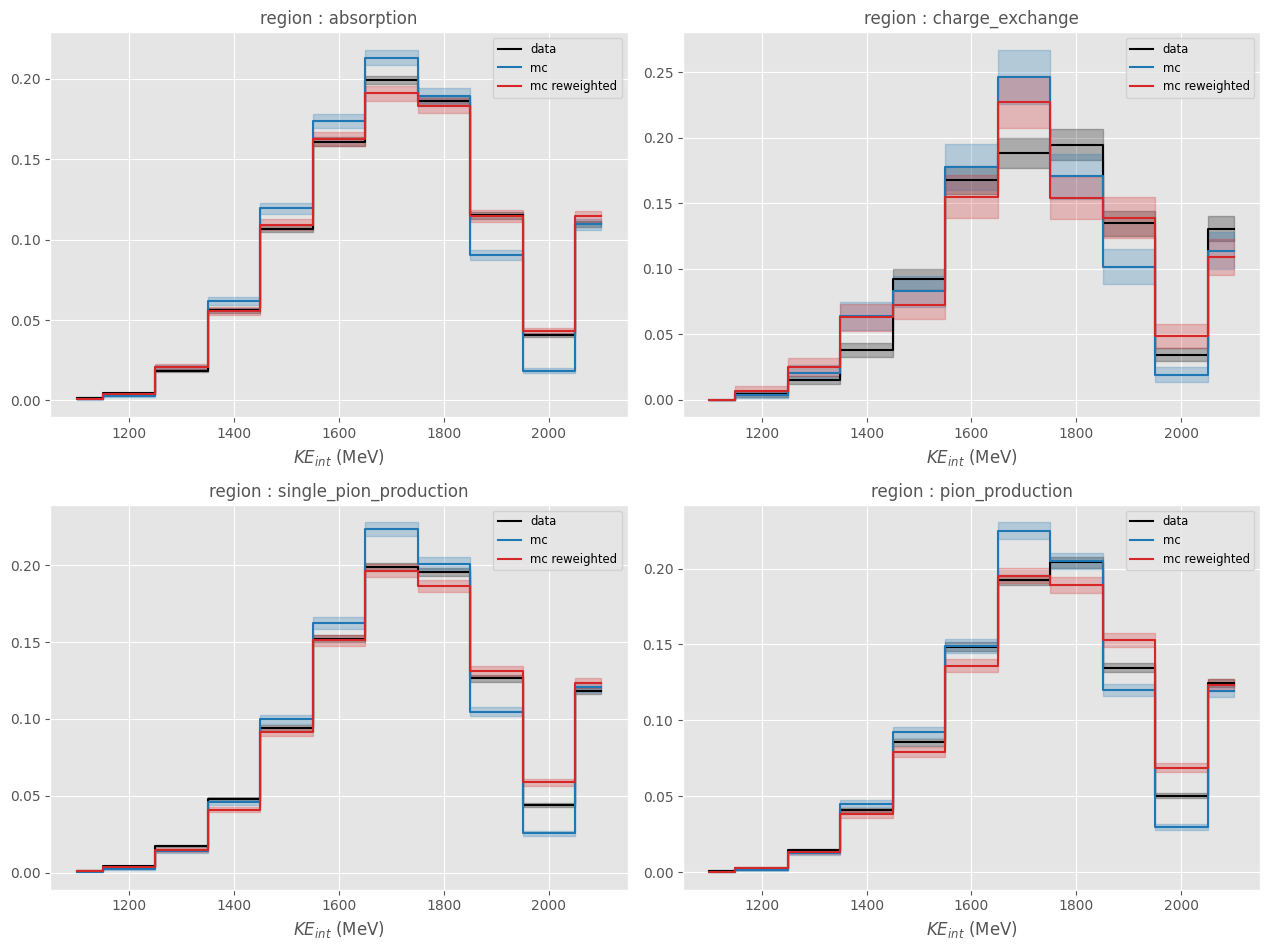

In [10]:
for _, r in Plots.IterMultiPlot(analysis_input_data_s.regions):
    n_int_data = analysis_input_data_s.NInteract(args.energy_slices, analysis_input_data_s.regions[r])
    n_int_mc = analysis_input_mc_s.NInteract(args.energy_slices, analysis_input_mc_s.regions[r], weights = analysis_input_mc_s.weights)
    n_int_mc_no_rw = analysis_input_mc_s.NInteract(args.energy_slices, analysis_input_mc_s.regions[r])
    Plots.Plot(args.energy_slices.pos_overflow, n_int_data / sum(n_int_data), yerr = np.sqrt(n_int_data) / sum(n_int_data), label = "data", style = "step", newFigure = False, color = "k")
    Plots.Plot(args.energy_slices.pos_overflow, n_int_mc_no_rw / sum(n_int_mc_no_rw), yerr = np.sqrt(n_int_mc_no_rw) / sum(n_int_mc_no_rw), label = "mc", style = "step", newFigure = False, xlabel = "$KE_{int}$ (MeV)", title = f"region : {r}", color = "C0")
    Plots.Plot(args.energy_slices.pos_overflow, n_int_mc / sum(n_int_mc), yerr = np.sqrt(n_int_mc) / sum(n_int_mc), label = "mc reweighted", style = "step", newFigure = False, color = "C6")
book.Save()

In [22]:
def DataFitStudy(data : cross_section.AnalysisInput, mc : cross_section.AnalysisInput, mc_stat_unc):
    result = cex_analyse.RegionFit(data, args.energy_slices, None, mc, True, False, True, mc_stat_unc = mc_stat_unc, single_bin = True)

    mean_track_score_weights = None

    result_mean_track_score = cex_analyse.RegionFit(data, args.energy_slices, mean_track_score_bins, mc, False, mean_track_score_weights, True, mc_stat_unc = mc_stat_unc, single_bin = True)


    scale = len(analysis_input_mc_s.KE_int_reco) / len(analysis_input_data_s.KE_int_reco)
    print(f"{scale=}")
    print("with mean track score")
    display(cross_section.pd.DataFrame({"fit value" : result_mean_track_score[1].bestfit[0:4] * scale, "uncertainty" : result_mean_track_score[1].uncertainty[0:4] * scale}))
    print("without mean track score")
    display(cross_section.pd.DataFrame({"fit value" : result[1].bestfit[0:4] * scale, "uncertainty" : result[1].uncertainty[0:4] * scale}))
    return result, result_mean_track_score


fit_results_rw = DataFitStudy(analysis_input_data_s, analysis_input_mc_s, True)
fit_results_rw_no_stat_err = DataFitStudy(analysis_input_data_s, analysis_input_mc_s, False)

no_rw = cross_section.AnalysisInput.FromFile("test/analysis_inputs/analysis_input_2GeV_mc_selected.dill")
no_rw.weights = None
fit_results_no_rw = DataFitStudy(analysis_input_data_s, no_rw, True)


  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
n_int=[25556]
n_int=[1448]
n_int=[28802]
n_int=[16974]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-23364.47015403])
  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2'

scale=0.40467161308051663

with mean track score

,fit value,uncertainty
0,9.293034e-12,0.099547
1,2.504857e+00,0.168746
2,5.235640e-01,0.061544
3,1.285350e+00,0.065702


without mean track score

,fit value,uncertainty
0,3.011998,0.913475
1,1.298178,0.313149
2,0.693125,0.228854
3,0.895440,0.109481


  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []
n_int=[25556]
n_int=[1448]
n_int=[28802]
n_int=[16974]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-23374.96649207])
  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0


scale=0.40467161308051663

with mean track score

,fit value,uncertainty
0,1.119884e-12,0.019600
1,2.410317e+00,0.045165
2,5.543322e-01,0.018706
3,1.270644e+00,0.018691


without mean track score

,fit value,uncertainty
0,3.011971,0.285022
1,1.298193,0.099050
2,0.693131,0.071948
3,0.895436,0.034700


  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
n_int=[25556]
n_int=[1448]
n_int=[28802]
n_int=[16974]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-23993.21486091])
  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2'

scale=0.40467161308051663

with mean track score

,fit value,uncertainty
0,1.544135e-10,0.099621
1,2.395098e+00,0.167070
2,4.977013e-01,0.062135
3,1.347776e+00,0.066656


without mean track score

,fit value,uncertainty
0,3.065302,1.044768
1,1.156425,0.367967
2,0.683293,0.247079
3,0.950800,0.119763


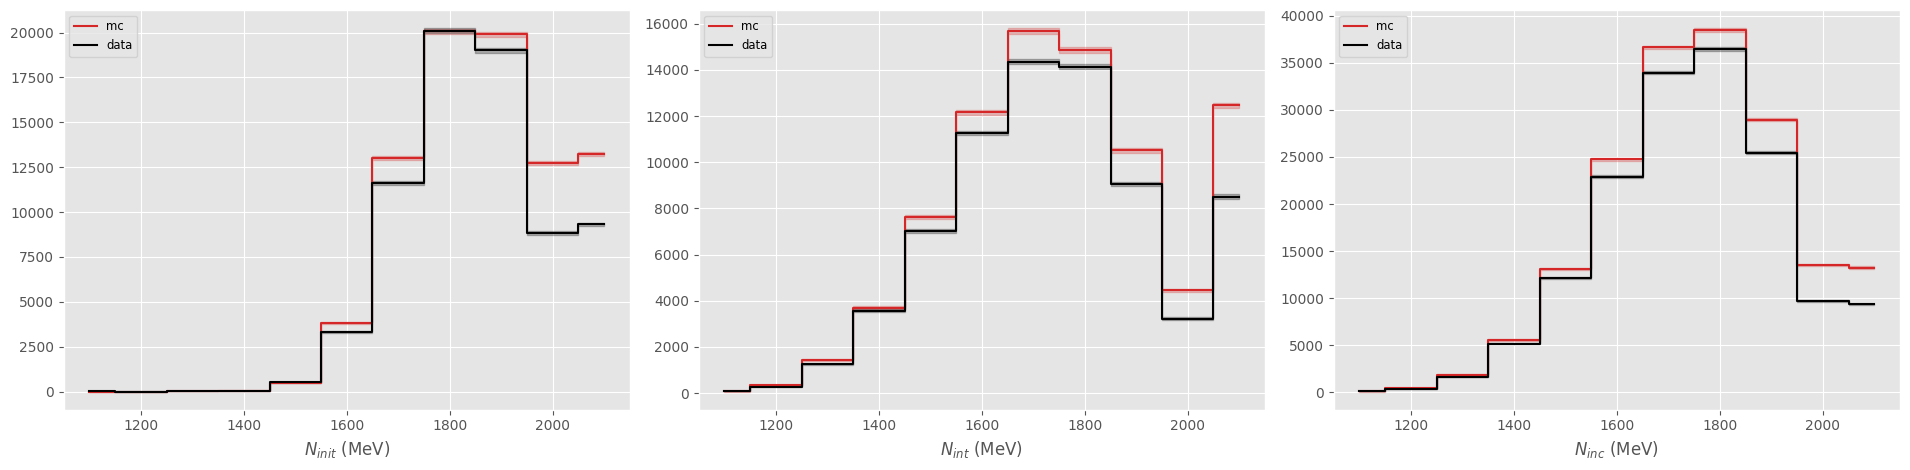

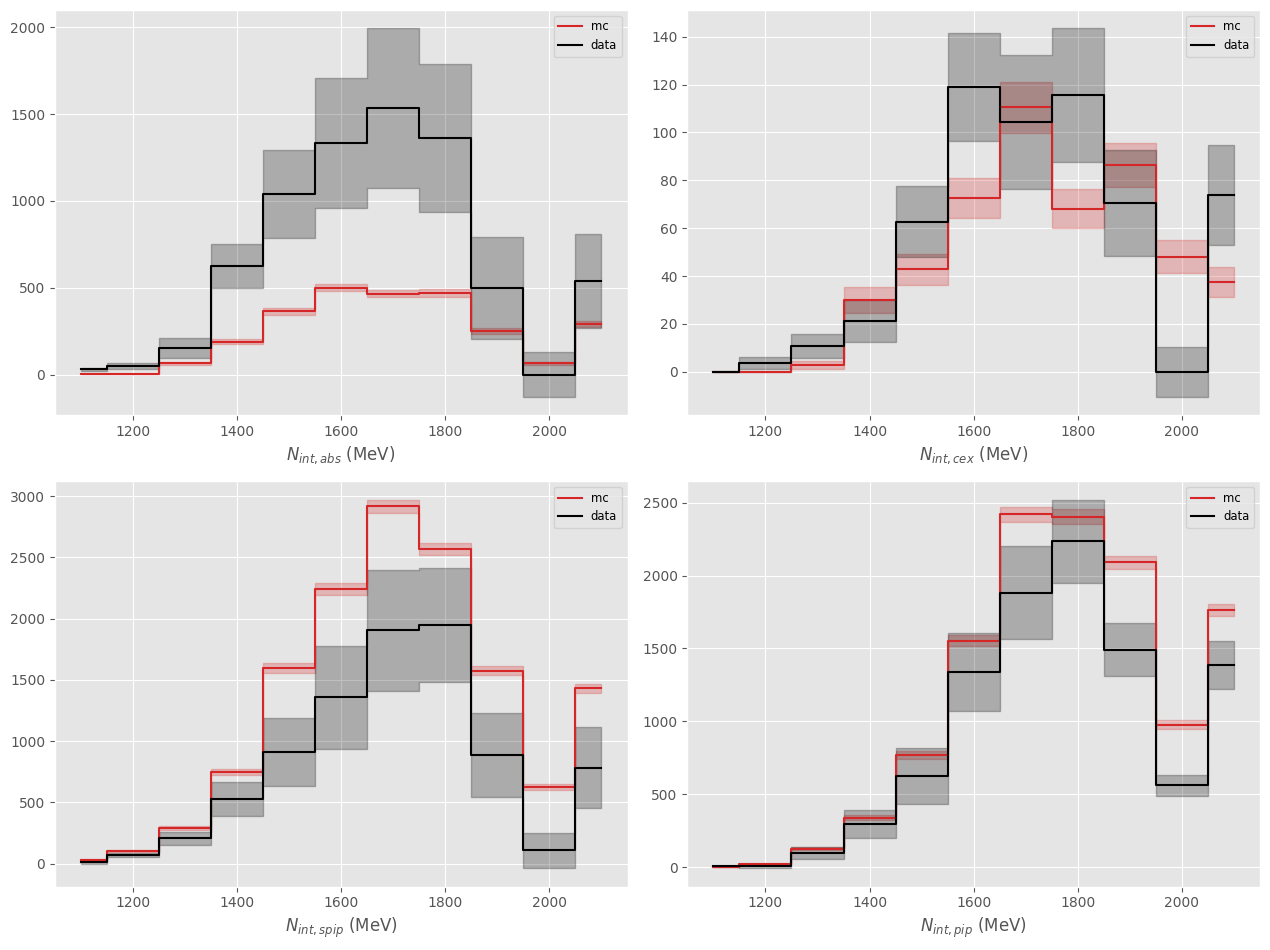

In [23]:
cex_analyse.PlotDataBkgSub(analysis_input_data_s, analysis_input_mc_s, fit_results_rw[0][0], True, True, "absorption", args.energy_slices, args.norm, "pdsp")


signal: charge_exchange

signal: charge_exchange

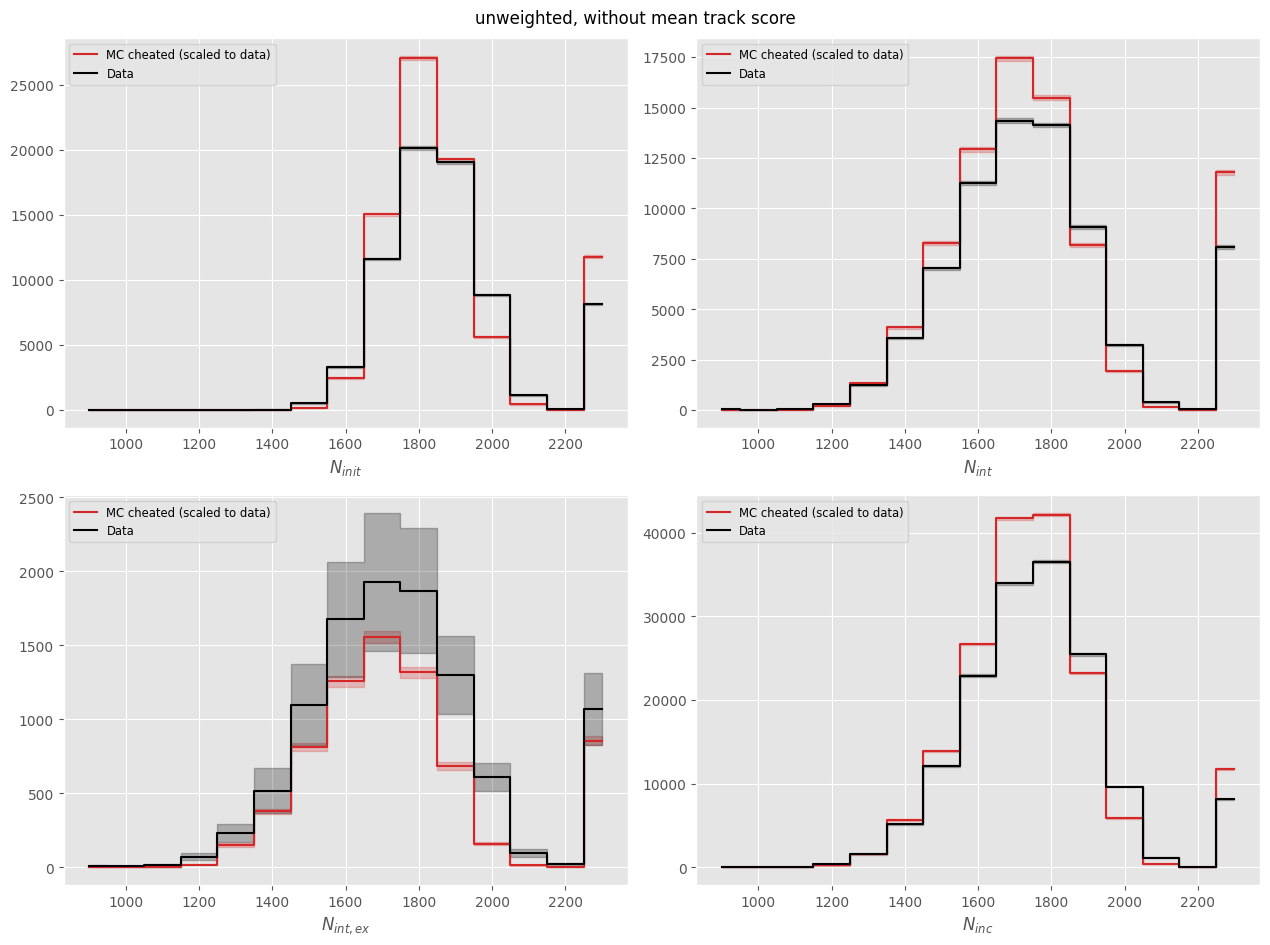

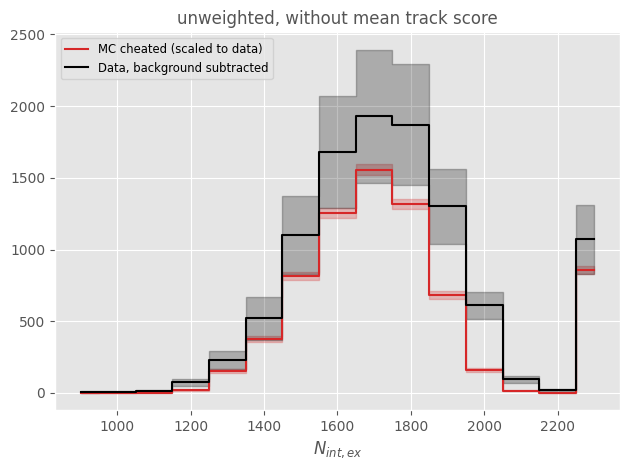

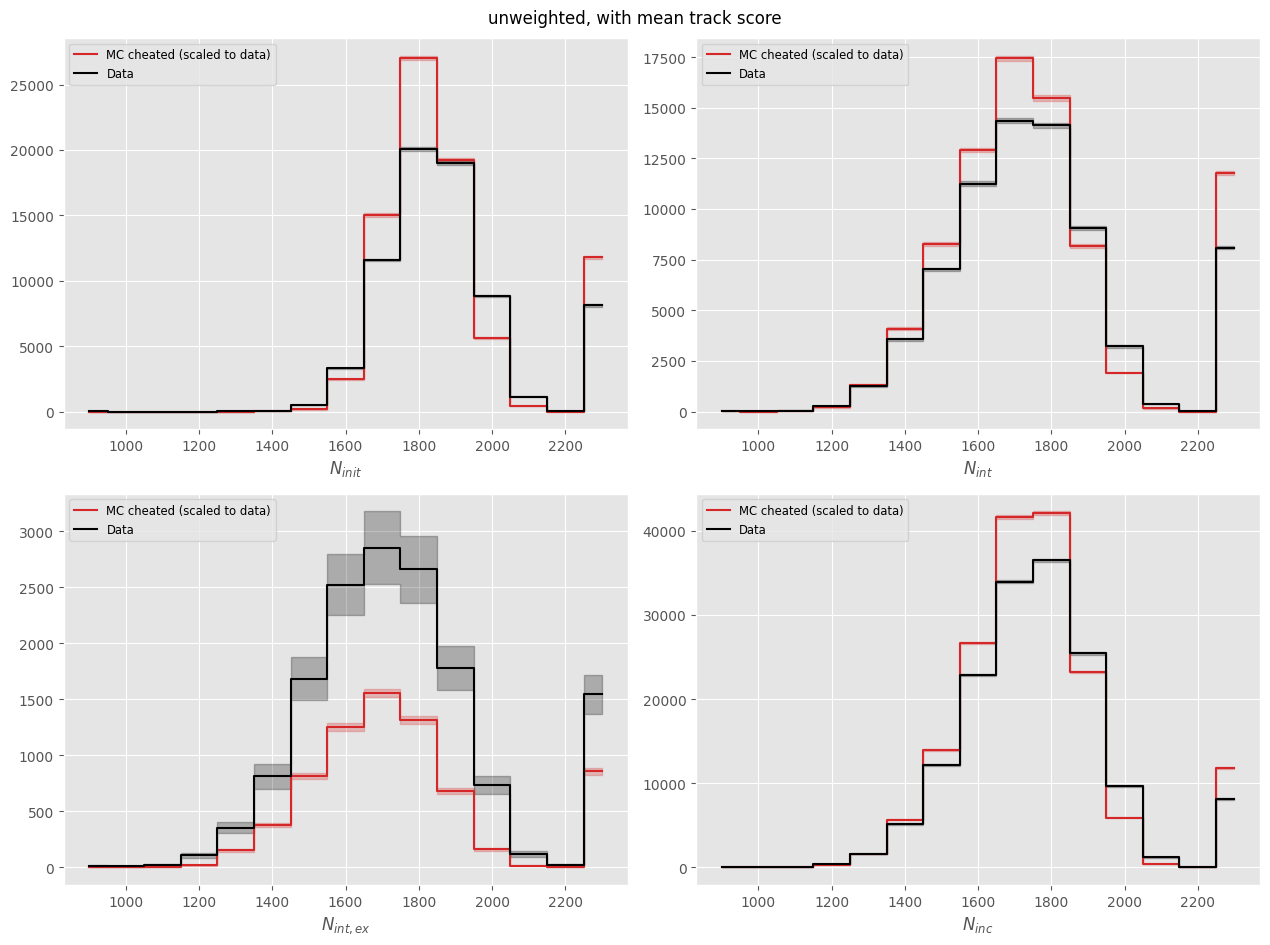

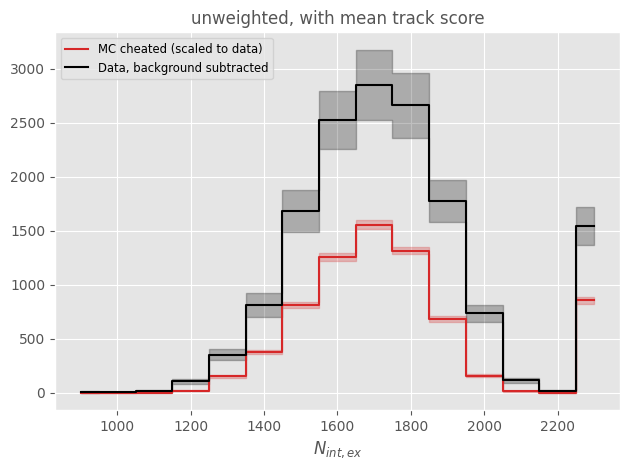

In [15]:
PlotDataBkgSub(analysis_input_data_s, no_rw, fit_results_no_rw[0][0], "unweighted, without mean track score", book)
PlotDataBkgSub(analysis_input_data_s, no_rw, fit_results_no_rw[1][0], "unweighted, with mean track score", book)

In [16]:
book.close()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


# Data MC unfolding

In [17]:
true_hists = analysis_input_mc.CreateHistograms(args.energy_slices, args.signal_process, False, ~analysis_input_mc.inclusive_process)
true_hists_selected = analysis_input_mc_s.CreateHistograms(args.energy_slices, args.signal_process, False, ~analysis_input_mc_s.inclusive_process)

efficiencies = cex_analyse.SelectionEfficiency(true_hists_selected, true_hists)

In [18]:
resp_e = cross_section.Unfold.CalculateResponseMatrices(analysis_input_mc, args.signal_process, args.energy_slices, None, {k : v[0] for k, v in efficiencies.items()})
resp = cross_section.Unfold.CalculateResponseMatrices(analysis_input_mc_s, args.signal_process, args.energy_slices, None, None)

In [19]:
dummy_efficiencies = {}
for h in true_hists_selected:
    err = np.nan_to_num(cross_section.nandiv(np.sqrt(true_hists_selected["init"]), true_hists_selected["init"]), 0)
    dummy_efficiencies[h] = [np.ones_like(err), err]

In [131]:
observed_data = {}
_, observed_data["value"], observed_data["error"] = cex_analyse.BackgroundSubtraction(analysis_input_data_s, args.signal_process, args.energy_slices, fit_results_rw[0][0])

observed_mc = {"value" : analysis_input_mc_s.CreateHistograms(args.energy_slices, args.signal_process, True, None)}
observed_mc["error"] = {k : np.sqrt(v) for k, v in observed_mc["value"].items()}

unfolding_no_efficiency_args = {"ts_stop" : 0.0001, "max_iter" : 6, "ts" : "ks", "method" : 1, "efficiencies" : dummy_efficiencies, "covariance" : "poisson"}
unfolding_no_efficiency = {
    "data" : cex_analyse.Unfolding(observed_data["value"], observed_data["error"], analysis_input_mc_s, unfolding_no_efficiency_args, args.signal_process, args.norm, args.energy_slices, analysis_input_mc, None),
    "mc" : cex_analyse.Unfolding(observed_mc["value"], observed_mc["error"], analysis_input_mc_s, unfolding_no_efficiency_args, args.signal_process, 1, args.energy_slices, analysis_input_mc, None)
}

signal: charge_exchange

Iteration 1: ts = 0.0249, ts_stopping = 0.0001
Iteration 2: ts = 0.0167, ts_stopping = 0.0001
Iteration 3: ts = 0.0116, ts_stopping = 0.0001
Iteration 4: ts = 0.0082, ts_stopping = 0.0001
Iteration 5: ts = 0.0060, ts_stopping = 0.0001
Iteration 6: ts = 0.0044, ts_stopping = 0.0001
Iteration 1: ts = 0.0262, ts_stopping = 0.0001
Iteration 2: ts = 0.0174, ts_stopping = 0.0001
Iteration 3: ts = 0.0125, ts_stopping = 0.0001
Iteration 4: ts = 0.0094, ts_stopping = 0.0001
Iteration 5: ts = 0.0073, ts_stopping = 0.0001
Iteration 6: ts = 0.0057, ts_stopping = 0.0001
Iteration 1: ts = 0.0242, ts_stopping = 0.0001
Iteration 2: ts = 0.0077, ts_stopping = 0.0001
Iteration 3: ts = 0.0030, ts_stopping = 0.0001
Iteration 4: ts = 0.0017, ts_stopping = 0.0001
Iteration 5: ts = 0.0016, ts_stopping = 0.0001
Iteration 6: ts = 0.0014, ts_stopping = 0.0001
Iteration 1: ts = 0.0229, ts_stopping = 0.0001
Iteration 2: ts = 0.0104, ts_stopping = 0.0001
Iteration 3: ts = 0.0049, ts_stopping = 0.0001
Iteration 4: 

In [132]:
unfolding_efficiency_args = {"ts_stop" : 0.01, "max_iter" : 100, "ts" : "ks", "method" : 2}
unfolding_efficiency = {
    "data" : cex_analyse.Unfolding(observed_data["value"], observed_data["error"], analysis_input_mc_s, unfolding_efficiency_args, args.signal_process, args.norm, args.energy_slices, analysis_input_mc, None),
    "mc" : cex_analyse.Unfolding(observed_mc["value"], observed_mc["error"], analysis_input_mc_s, unfolding_efficiency_args, args.signal_process, 1, args.energy_slices, analysis_input_mc, None)
}

Iteration 1: ts = 0.2703, ts_stopping = 0.01
Iteration 2: ts = 0.0815, ts_stopping = 0.01
Iteration 3: ts = 0.0290, ts_stopping = 0.01
Iteration 4: ts = 0.0118, ts_stopping = 0.01
Iteration 5: ts = 0.0051, ts_stopping = 0.01
Iteration 1: ts = 0.2728, ts_stopping = 0.01
Iteration 2: ts = 0.0845, ts_stopping = 0.01
Iteration 3: ts = 0.0280, ts_stopping = 0.01
Iteration 4: ts = 0.0109, ts_stopping = 0.01
Iteration 5: ts = 0.0074, ts_stopping = 0.01
Iteration 1: ts = 0.2501, ts_stopping = 0.01
Iteration 2: ts = 0.0708, ts_stopping = 0.01
Iteration 3: ts = 0.0220, ts_stopping = 0.01
Iteration 4: ts = 0.0136, ts_stopping = 0.01
Iteration 5: ts = 0.0088, ts_stopping = 0.01
Iteration 1: ts = 0.2506, ts_stopping = 0.01
Iteration 2: ts = 0.0835, ts_stopping = 0.01
Iteration 3: ts = 0.0340, ts_stopping = 0.01
Iteration 4: ts = 0.0160, ts_stopping = 0.01
Iteration 5: ts = 0.0082, ts_stopping = 0.01
Iteration 1: ts = 0.2524, ts_stopping = 0.01
Iteration 2: ts = 0.0892, ts_stopping = 0.01
Iteration 

{'data unfolded, efficiency correction': 25.852718965766304,
 'mc unfolded, efficiency correction': 58.27123327148362,
 'mc true': 3.6896235959994828}

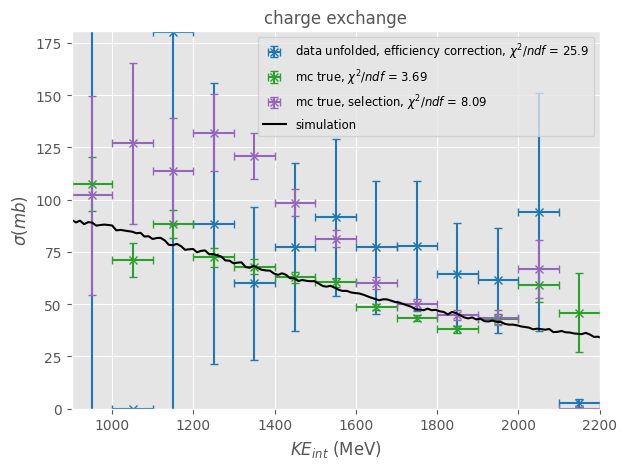

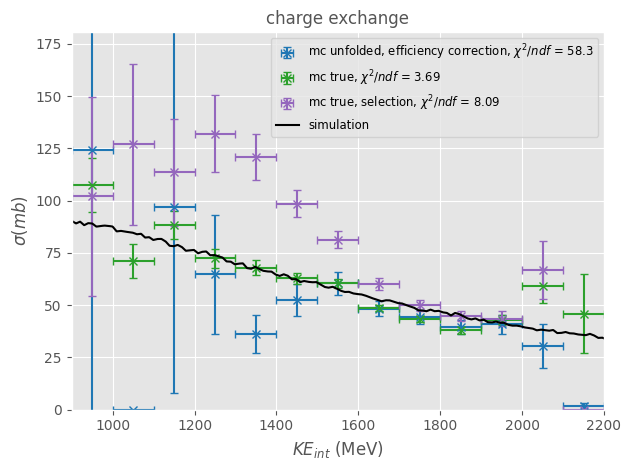

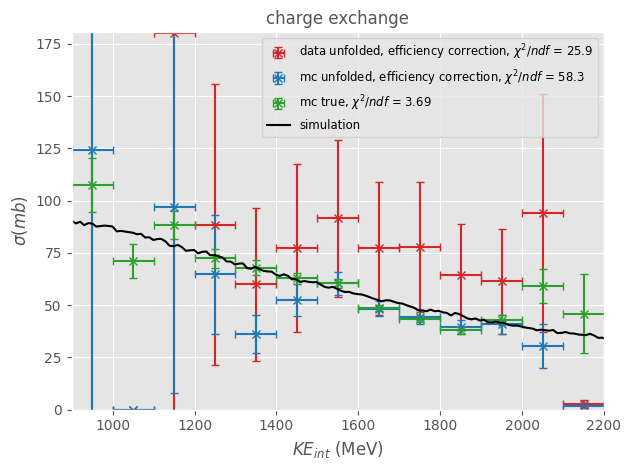

In [133]:
xs_data = cex_analyse.XSUnfold(unfolding_no_efficiency["data"], args.energy_slices, True)
xs_mc = cex_analyse.XSUnfold(unfolding_no_efficiency["mc"], args.energy_slices)

xs_true = cross_section.EnergySlice.CrossSection(true_hists["int_ex"][1:], true_hists["int"][1:], true_hists["inc"][1:], cross_section.BetheBloch.meandEdX(args.energy_slices.pos_bins[1:], cross_section.Particle.from_pdgid(211)), args.energy_slices.width)
xs_true_selected = cross_section.EnergySlice.CrossSection(true_hists_selected["int_ex"][1:], true_hists_selected["int"][1:], true_hists_selected["inc"][1:], cross_section.BetheBloch.meandEdX(args.energy_slices.pos_bins[1:], cross_section.Particle.from_pdgid(211)), args.energy_slices.width)

cross_section.PlotXSComparison(
    {"data unfolded, efficiency correction" : xs_data, "mc true" : xs_true, "mc true, selection" : xs_true_selected},
    args.energy_slices,
    "charge_exchange",
    {"data unfolded, efficiency correction" : "C0", "mc true" : "C4", "mc true, selection" : "C8"}
    )
cross_section.PlotXSComparison(
    {"mc unfolded, efficiency correction" : xs_mc, "mc true" : xs_true, "mc true, selection" : xs_true_selected},
    args.energy_slices,
    "charge_exchange",
    {"mc unfolded, efficiency correction" : "C0", "mc true" : "C4", "mc true, selection" : "C8"}
    )
cross_section.PlotXSComparison(
    {"data unfolded, efficiency correction" : xs_data, "mc unfolded, efficiency correction" : xs_mc, "mc true" : xs_true},
    args.energy_slices,
    "charge_exchange",
    {"data unfolded, efficiency correction" : "C6", "mc unfolded, efficiency correction" : "C0", "mc true" : "C4"}
    )

{'data unfolded with efficiency': 2.0713908325138215,
 'mc unfolded with efficiency': 9.006719904914762,
 'mc true': 3.6896235959994828}

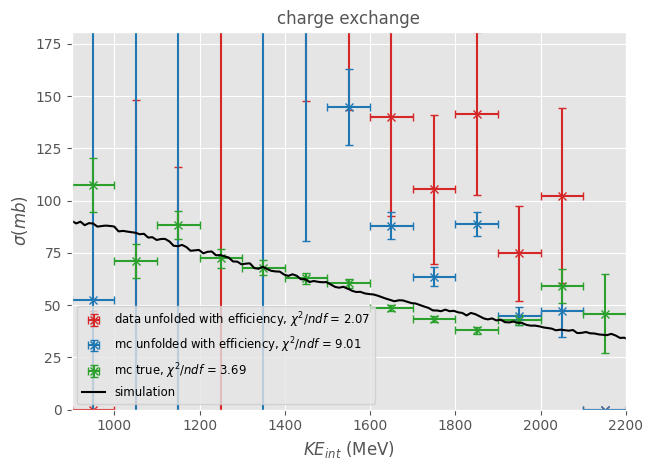

In [134]:
xs_data_2 = cex_analyse.XSUnfold(unfolding_efficiency["data"], args.energy_slices)
xs_mc_2 = cex_analyse.XSUnfold(unfolding_efficiency["mc"], args.energy_slices)

cross_section.PlotXSComparison(
    {"data unfolded with efficiency" : xs_data_2, "mc unfolded with efficiency" : xs_mc_2, "mc true" : xs_true},
    args.energy_slices,
    "charge_exchange",
    {"data unfolded with efficiency" : "C6", "mc unfolded with efficiency" : "C0", "mc true" : "C4"}
    )

{'data, unfolding method 1': 25.852718965766304,
 'data, unfolding method 2': 2.0713908325138215,
 'mc true': 3.6896235959994828}

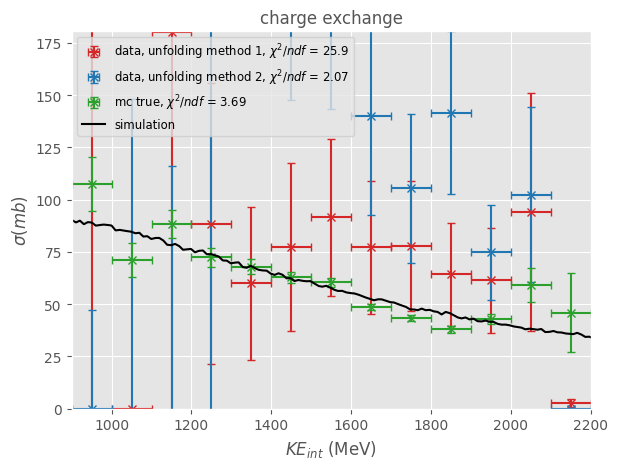

In [135]:
# method 1 is unfold, then apply efficeincy corrections after unfolding (Yinrui's method)
# method 2 is unfold with efficiency applied to respone matrix
cross_section.PlotXSComparison(
    {"data, unfolding method 1" : xs_data, "data, unfolding method 2" : xs_data_2, "mc true" : xs_true},
    args.energy_slices,
    "charge_exchange",
    {"data, unfolding method 1" : "C6", "data, unfolding method 2" : "C0", "mc true" : "C4"}
    )

{'data, stat err': 25.852718965766304, 'mc true': 3.6896235959994828}

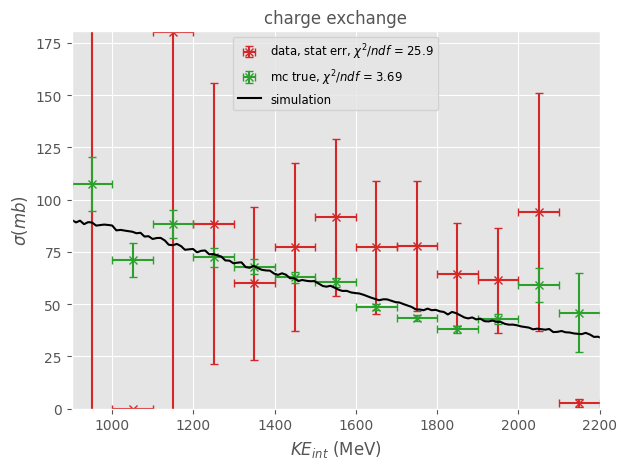

In [136]:
# method 1 is unfold, then apply efficeincy corrections after unfolding (Yinrui's method)
# method 2 is unfold with efficiency applied to respone matrix
cross_section.PlotXSComparison(
    {"data, stat err" : xs_data, "mc true" : xs_true},
    args.energy_slices,
    "charge_exchange",
    {"data, stat err" : "C6", "mc true" : "C4"}
    )

# Unfolding debug

In [34]:
_, hists_data, hists_data_err = cex_analyse.BackgroundSubtraction(analysis_input_data_s, "absorption", args.energy_slices, fit_results_rw[0][0], True, True, analysis_input_mc_s)

mc_true_hists_selected = analysis_input_mc_s.CreateHistograms(args.energy_slices, "absorption", False, ~analysis_input_mc_s.inclusive_process)
mc_true_hists_selected_regions = {i : analysis_input_mc_s.NInteract(args.energy_slices, analysis_input_mc_s.exclusive_process[i], analysis_input_mc_s.regions[i], False, analysis_input_mc_s.weights) for i in analysis_input_mc_s.exclusive_process}

mc_reco_hists_selected = analysis_input_mc_s.CreateHistograms(args.energy_slices, "absorption", True, ~analysis_input_mc_s.inclusive_process)
mc_reco_hists_selected_regions = {i : analysis_input_mc_s.NInteract(args.energy_slices, analysis_input_mc_s.exclusive_process[i], analysis_input_mc_s.regions[i], True, analysis_input_mc_s.weights) for i in analysis_input_mc_s.exclusive_process}


resp = cross_section.Unfold.CalculateResponseMatrices(analysis_input_mc_s, "absorption", args.energy_slices, True, None, None)

In [40]:
hists_data

{'init': array([ 9321,  8843, 19025, 20104, 11597,  3308,   513,    39,    13,
            2,    15]),
 'int': array([ 8512,  3220,  9062, 14140, 14358, 11264,  7025,  3569,  1245,
          286,    99]),
 'int_ex': {'absorption': array([ 540.42471427,    0.        ,  499.11421204, 1359.84488543,
         1532.63387918, 1334.31309462, 1040.16610066,  623.28593505,
          153.6838493 ,   49.28634593,   29.59716978]),
  'charge_exchange': array([ 73.85924648,   0.        ,  70.52160367, 115.44724718,
         104.25254468, 118.95333795,  62.6084176 ,  21.19754008,
          10.79807623,   3.71793296,   0.        ]),
  'single_pion_production': array([ 781.57098975,  106.23104552,  885.46027874, 1946.7730571 ,
         1905.94837723, 1356.63448475,  911.97003473,  525.82246128,
          204.76491983,   67.29864555,    9.07471047]),
  'pion_production': array([1386.57844674,  560.08961252, 1491.1006656 , 2234.16775898,
         1882.2995351 , 1339.51973652,  626.33938212,  293.92219044

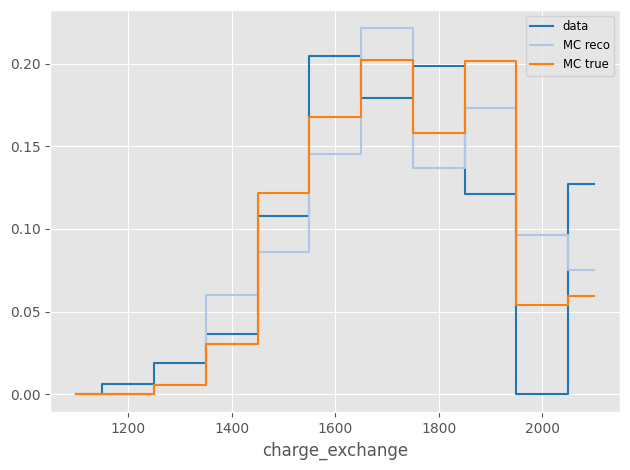

In [42]:
Plots.Plot(args.energy_slices.pos_overflow, hists_data["int_ex"]["charge_exchange"] / sum(hists_data["int_ex"]["charge_exchange"]), xlabel = "charge_exchange", style = "step", label = "data")
Plots.Plot(args.energy_slices.pos_overflow, mc_reco_hists_selected_regions["charge_exchange"] / sum(mc_reco_hists_selected_regions["charge_exchange"]), xlabel = "charge_exchange", style = "step", label = "MC reco", newFigure = False)
Plots.Plot(args.energy_slices.pos_overflow, mc_true_hists_selected_regions["charge_exchange"] / sum(mc_true_hists_selected_regions["charge_exchange"]), xlabel = "charge_exchange", style = "step", label = "MC true", newFigure = False)


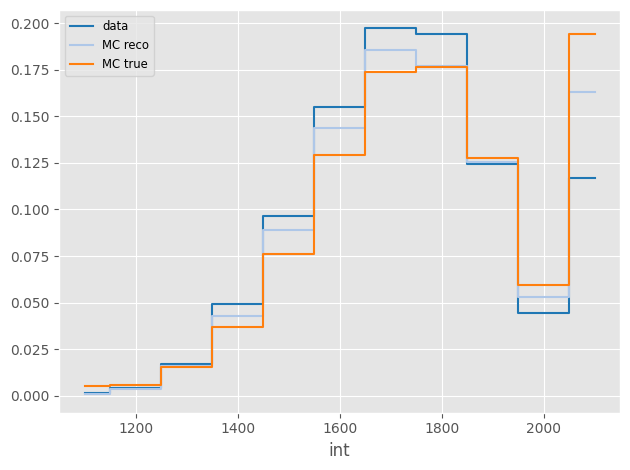

In [44]:
Plots.Plot(args.energy_slices.pos_overflow, hists_data["int"] / sum(hists_data["int"]), xlabel = "int", style = "step", label = "data")
Plots.Plot(args.energy_slices.pos_overflow, mc_reco_hists_selected["int"] / sum(mc_reco_hists_selected["int"]), xlabel = "int", style = "step", label = "MC reco", newFigure = False)
Plots.Plot(args.energy_slices.pos_overflow, mc_true_hists_selected["int"] / sum(mc_true_hists_selected["int"]), xlabel = "int", style = "step", label = "MC true", newFigure = False)


In [47]:
analysis_input_mc_s.weights

<Array [1.27, 0.727, 0.863, ... 0.85, 0.888] type='29452 * float64'>